In [161]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
ds = xr.open_dataset('../../NHCS/hincast_1980-2015/croco_avg_Y1980M01.nc', 
                     chunks = {'time':1})
ds

<xarray.Dataset> Size: 891MB
Dimensions:     (xi_rho: 602, xi_u: 601, eta_rho: 542, eta_v: 541, s_rho: 32,
                 s_w: 33, time: 1, auxil: 4)
Coordinates: (12/13)
  * xi_rho      (xi_rho) float64 5kB 1.0 2.0 3.0 4.0 ... 599.0 600.0 601.0 602.0
  * xi_u        (xi_u) float64 5kB 1.5 2.5 3.5 4.5 ... 598.5 599.5 600.5 601.5
  * eta_rho     (eta_rho) float64 4kB 1.0 2.0 3.0 4.0 ... 540.0 541.0 542.0
  * eta_v       (eta_v) float64 4kB 1.5 2.5 3.5 4.5 ... 538.5 539.5 540.5 541.5
  * s_rho       (s_rho) float64 256B -0.9844 -0.9531 ... -0.04688 -0.01562
  * s_w         (s_w) float64 264B -1.0 -0.9688 -0.9375 ... -0.0625 -0.03125 0.0
    ...          ...
    lat_rho     (eta_rho, xi_rho) float64 3MB dask.array<chunksize=(542, 602), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
  * time        (time) float32 4B 1.339e+06
Dimensions without coordinates: auxil
Data variables: (12/54)
    spherical   |S1 1B ...
    xl          float64 8B ...
    el          float64 8B ...
    Vtransform  float64 8B ...
    sc_r        (s_rho) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    sc_w        (s_w) float64 264B dask.array<chunksize=(33,), meta=np.ndarray>
    ...          ...
    swflux      (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    radsw       (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_rlw   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_lat   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_sen   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    hel         (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
Attributes: (12/57)
    type:           ROMS restart file
    title:          Peru UW Interannual Run
    date:           
    rst_file:       croco_rst.nc
    his_file:       croco_his.nc
    avg_file:       croco_avg.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL PERU_UW MPI OBC_WEST OBC_NORTH OBC_SOUTH BIOLOGY...

In [3]:
ds.lon_rho.compute().values[0,:].shape
ds.lat_rho.compute().values[:,0].shape

(542,)

## Functions

In [4]:
## Functions
## kml to struct
def kml2struct(kml_file):
    """
    Import a .kml file as a list of dictionary structures with fields:
    Geometry, Name, Description, Lon, Lat, and BoundingBox.
    """
    # Read the KML file
    try:
        with open(kml_file, 'r', encoding='utf-8') as file:
            txt = file.read()
    except Exception as e:
        raise FileNotFoundError(f"Unable to open file {kml_file}: {e}")

    # Regular expression to match Placemark tags
    expr = r"<Placemark.+?>.+?</Placemark>"
    object_strings = re.findall(expr, txt, re.DOTALL)
    
    kml_struct = []

    for obj_str in object_strings:
        # Extract Name
        name_match = re.search(r"<name.*?>(.*?)</name>", obj_str, re.DOTALL)
        name = name_match.group(1).strip() if name_match else "undefined"

        # Extract Description
        desc_match = re.search(r"<description.*?>(.*?)</description>", obj_str, re.DOTALL)
        desc = desc_match.group(1).strip() if desc_match else ""

        # Determine Geometry Type
        geometry = ""
        if "<Point" in obj_str:
            geometry = "Point"
        elif "<LineString" in obj_str:
            geometry = "Line"
        elif "<Polygon" in obj_str:
            geometry = "Polygon"

        # Extract Coordinates
        coord_match = re.search(r"<coordinates.*?>(.*?)</coordinates>", obj_str, re.DOTALL)
        if not coord_match:
            continue  # Skip if no coordinates are found
        coord_str = coord_match.group(1).strip()
        coord_list = np.array([list(map(float, coord.split(','))) for coord in coord_str.split()])

        # Separate Lon, Lat, and handle Polygons
        lon = coord_list[:, 0]
        lat = coord_list[:, 1]
        if geometry == "Polygon":
            # Close the polygon by appending NaN
            lon = np.append(lon, np.nan)
            lat = np.append(lat, np.nan)

        # Create BoundingBox
        bounding_box = [[lon.min(), lat.min()], [lon.max(), lat.max()]]

        # Append to kml_struct
        kml_struct.append({
            "Geometry": geometry,
            "Name": name,
            "Description": desc,
            "Lon": lon,
            "Lat": lat,
            "BoundingBox": bounding_box
        })

    return kml_struct

In [5]:
# Load the KML file to get the polygon boundary
arch_kml_zona1 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK150km.kml"
R1 = kml2struct(arch_kml_zona1)

# Extract Lon and Lat from the first polygon
lonb1 = R1[0]["Lon"]
latb1 = R1[0]["Lat"]

## Lon and lat for the whole dataset
lat = np.linspace(-33.0, 10.03286, 542).reshape(542, 1)  # Reshape to match eta_rho
lon = np.linspace(-118.9083, -68.90833, 602).reshape(1, 602)  # Reshape to match xi_rho

lats, lons = np.meshgrid(lat.flatten(), lon.flatten(), indexing="ij")

LON=lons
LAT=lats
# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask = np.where(mask, 1, np.nan)

In [6]:
Puertos = {
    # "Inglés": [-17.65611111,  -71.35083333],
    # "Ilo": [-17.64138889, -71.34777778],
    # "Pacocha":[-17.28,    -71.34333333],
    # "Mollendo":   [-17.03722222,  -72.00416667],
    # #"Matarani":  [-16.99583333,  -72.105],
    # "Quilca": [-16.71166667,  -72.43333333],
    # "La Planchada":   [-16.40472222,  -73.21277778],
    # "Camana":     [-16.64722222,  -72.70055556],
    # "Ilo":    [-17.63388889,  -71.33944444],
    # "M. Sama":    [-17.97166667,  -70.89027778],
    # "L. Palos":   [-18.27638889,  -70.47555556],
    # "Atico":  [-16.22388889,  -73.69916667],
    # "Chala":  [-15.81555556,  -74.42166667],
    # "Punta Infiernillos": [-14.52,    -75.9],
    # "Punta Caballa":  [-14.94972222,  -75.49833333],
    # "San Juan":   [-15.36638889, -75.17055556],
    # #"Lomas": [-15.55777778,  -74.85],
    # "San Juan":   [-15.34888889,  -75.16027778],
    # "San Nicolás":    [-15.25,    -75.24166667],
    # "Bahia Independencia": [-14.2522222222222, -76.1347222222222],
    #"General San Martín": [-13.8, -76.28916667],
    "Pisco":  [-13.69388889,  -76.22416667],
    # "Tambo de Mora":[-13.455, -76.18972222],
    # "Cerro Azul":   [-13.02055556,  -76.48555556],
    # #"Bujama":  [-12.7225,  -77.62944444],
    # "Pucusana":[-12.4977777777778,  -76.7952777777778],
    # "Chorrillos":[-12.15638889, -77.03194444],
    "Callao":   [-12.0575,  -77.15305556],
    # "Ancón":    [-11.76416667,  -77.17694444],
    # "Chancay":  [-11.575,   -77.27361111],
    # "Huacho":   [-11.11055556,  -77.62027778],
    # #"Carquín": [-11.08166667,  -77.63333333],
    # "Vegeta":   [-11,   -77.675],
    # "Supe": [-11.4758333333333, -77.50],
    # "Barranca":[-10.76222222,   -77.76583333],
    # "Punta Bermejo":[-10.4730555555556, -77.9661111111111],
    # "Las Zorras":[-10.2686111111111, -78.0788888888889],
    # "Huarmey":[-10.08916667,    -78.17166667],
    # "Culebras"  :[-9.945,   -78.23333333],
    # #"Tortugas":    [-9.337777778,  -77.405],
    # "Samanco":  [-9.237777778,  -78.50277778],
    "Chimbote": [-9.076666667,  -78.61472222],
    #"Santa":   [-8.977777778,  -78.65333333],
    # "Punta Chao":[-8.74138888888889,-78.7497222222222],
    # #"Coscobamba":   [-8.656944444,  -78.76111111],
    # "Casma" :[-9.43694444444444,    -78.385],
    # "Guañape":  [-8.416666667,  -78.89388889],
    # "Salaverry":    [-8.224444444,  -78.98166667],
    # "Huanchaco":    [-8.073333333,  -79.12333333],
    # "Chicama"   :[-7.703611111, -79.45916667],
    # "Pacasmayo":[-7.386944444,  -79.58833333],
    # "Chérrepe": [-7.153333333,  -79.70166667],
    # #"Lagunas":[-7.088333333,   -79.73055556],
    # "Eten": [-6.943333333,  -79.87972222],
    # #"Santa Rosa":  [-6.896666667,  -79.94166667],
    # "Pimentel": [-6.847777778,  -79.95583333],
    # #"San José":    [-6.798333333,  -79.99166667],
    # "Morrope":[-6.55027777777778,-80.2438888888889],
    # "Punta La Negra":[-5.98,-81.1491666666667],
    # "Mancora":  [-5.79, -81.06083333],
    # #"Parachique":[-5.67,-80.838333],
    # "Sechura":[-5.55694,-80.82222],
    # "Punta Gobernador":[-5.3144,-81.1050],
    "Paita":    [-5.078055556,  -81.10638889],
    # "Negritos": [-4.644166667,  -81.32222222],
    # #"Talara":  [-4.570277778,  -81.27972222],
    # "Lobitos":  [-4.4375,   -81.28416667],
    # "Cabo Blanco":  [-4.242777778,  -81.22888889],
    # "Los Órganos":  [-4.171944444,  -81.13333333],
    # "Cancas":   [-3.943611111,  -80.94388889],
    # "Zorritos": [-3.685277778,  -80.67138889],
    # "Puerto Pizarro":   [-3.513055556,  -80.40333333]
    }

In [7]:
##Normalize
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

## Load the Indices

### CUI

/tmp/ipykernel_1762042/2666954542.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time = pd.date_range(start='1980-01', end='2016-01', freq='M')


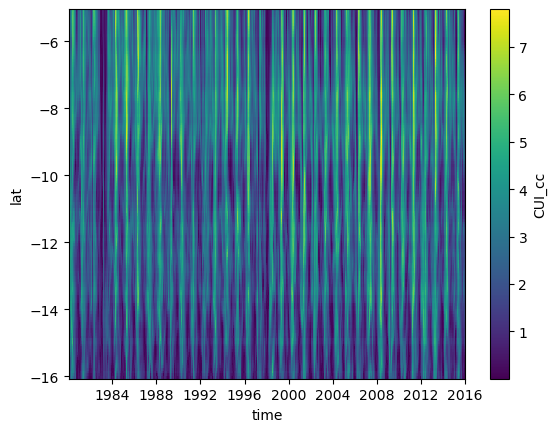

In [8]:
## generate time
time = pd.date_range(start='1980-01', end='2016-01', freq='M')
##CUI_model
CUI_db = loadmat("../../NHCS/Processed/CUI_SST_index.mat")
CUI_cc = np.array(CUI_db['CUI_SSTi']).squeeze()
lati_cc = np.array(CUI_db['lati']).squeeze()
#print(CUI.keys())
CUI_cc.shape

CUI_ds = xr.DataArray(
    data=CUI_cc.T,  # numpy array of Mean_CUI
    dims=["time",'lat'],  # Dimension matches the time in CUI_MAX
    coords={"time": time,
           'lat': lati_cc},  # Ensure matching time coordinates
    name="CUI_cc"  # Name for the variable
)

CUI_ds.sel(lat=CUI_ds['lat'] >-16.1).plot(y='lat')

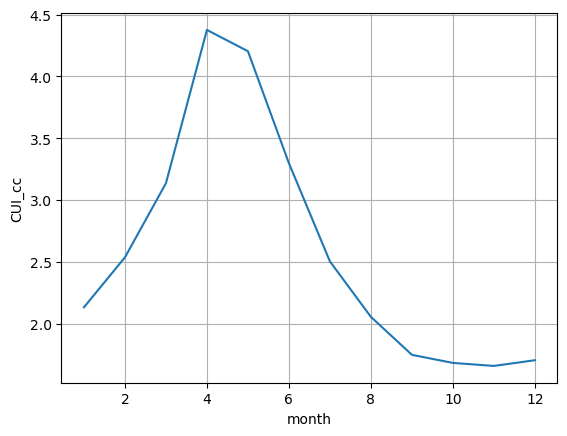

In [9]:
CUI_cut = CUI_ds.sel(lat=CUI_ds['lat'] >-16)
CUI_mmean = CUI_cut.mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
CUI_anomaly = CUI_cut.mean(dim='lat', skipna=True).groupby('time.month') - CUI_mmean

CUI_mmean.plot()
plt.grid(True)


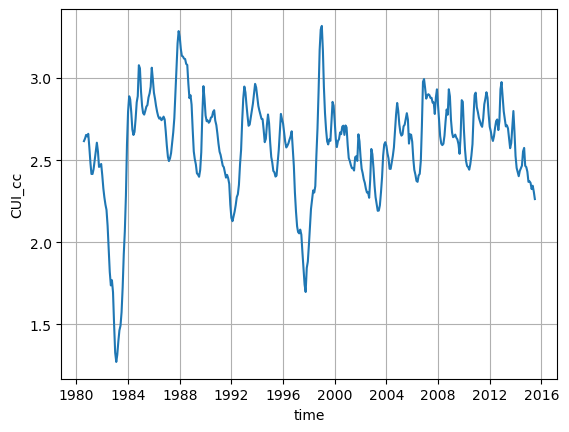

In [10]:
CUI_ts=CUI_cut.mean(dim=('lat'),skipna=True).rolling(time=13,center=True).mean()
CUI_ts.plot()
plt.grid(True)

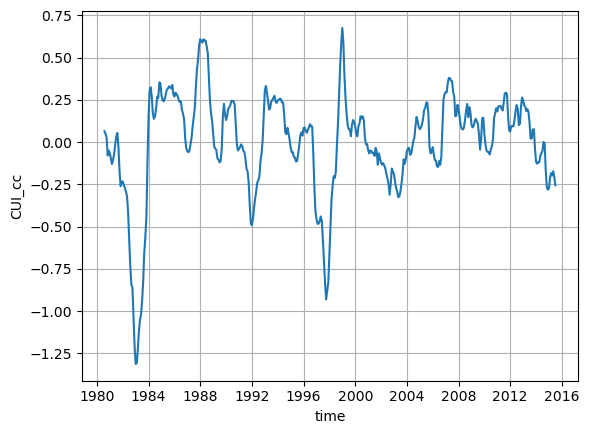

In [11]:
CUI_anomaly.rolling(time=13,center=True).mean().plot()
plt.grid(True)

### EKMAN

In [12]:
## Ekman pump
Ekman_data = loadmat("../../NHCS/Processed/EKMAN_components.mat")
# Ekman_data2 = loadmat("../../NHCS/Processed/Ekman_pump_2.mat") #calculated with formula
Ek_pump = Ekman_data['EK_pump']
# ## Ekman transport
Ek_tr = Ekman_data['UEK']*-1

Ek_pump.shape #lon, lat, time

(602, 542, 432)

In [13]:
EK_ds = xr.Dataset(
    data_vars={
        'Ekman_pump': (("time", "lat","lon"), Ek_pump.transpose(2, 1, 0)),
        'Ekman_transport':(("time", "lat","lon"), Ek_tr.transpose(2, 1, 0))
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

EK_ds

<xarray.Dataset> Size: 2GB
Dimensions:          (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon              (lon) float64 5kB -119.0 -118.9 -118.8 ... -68.95 -68.87
  * lat              (lat) float64 4kB -33.0 -32.93 -32.86 ... 9.869 9.951 10.03
  * time             (time) datetime64[ns] 3kB 1980-01-31 ... 2015-12-31
Data variables:
    Ekman_pump       (time, lat, lon) float64 1GB 3.175e-07 4.708e-07 ... nan
    Ekman_transport  (time, lat, lon) float64 1GB -0.09788 -0.102 ... nan nan

In [14]:
EK_ds['Ekman_pump'] = EK_ds['Ekman_pump'] * inshore_mask
EK_ds['Ekman_transport'] = EK_ds['Ekman_transport'] * inshore_mask

EK_pump = EK_ds['Ekman_pump'].where((EK_ds.lat >= -16) & (EK_ds.lat <= -5) & 
                  (EK_ds.lon >= -90) & (EK_ds.lon <= -65), drop=True)

EK_tr = EK_ds['Ekman_transport'].where((EK_ds.lat >= -16) & (EK_ds.lat <= -5) & 
                  (EK_ds.lon >= -90) & (EK_ds.lon <= -65), drop=True)

### ds storing
EK_ds['Ekman_pump'] = EK_ds['Ekman_pump'].where((EK_ds.lat >= -16) & (EK_ds.lat <= -5) & 
                  (EK_ds.lon >= -90) & (EK_ds.lon <= -65), drop=True)

EK_ds['Ekman_transport'] = EK_ds['Ekman_transport'].where((EK_ds.lat >= -16) & (EK_ds.lat <= -5) & 
                  (EK_ds.lon >= -90) & (EK_ds.lon <= -65), drop=True)


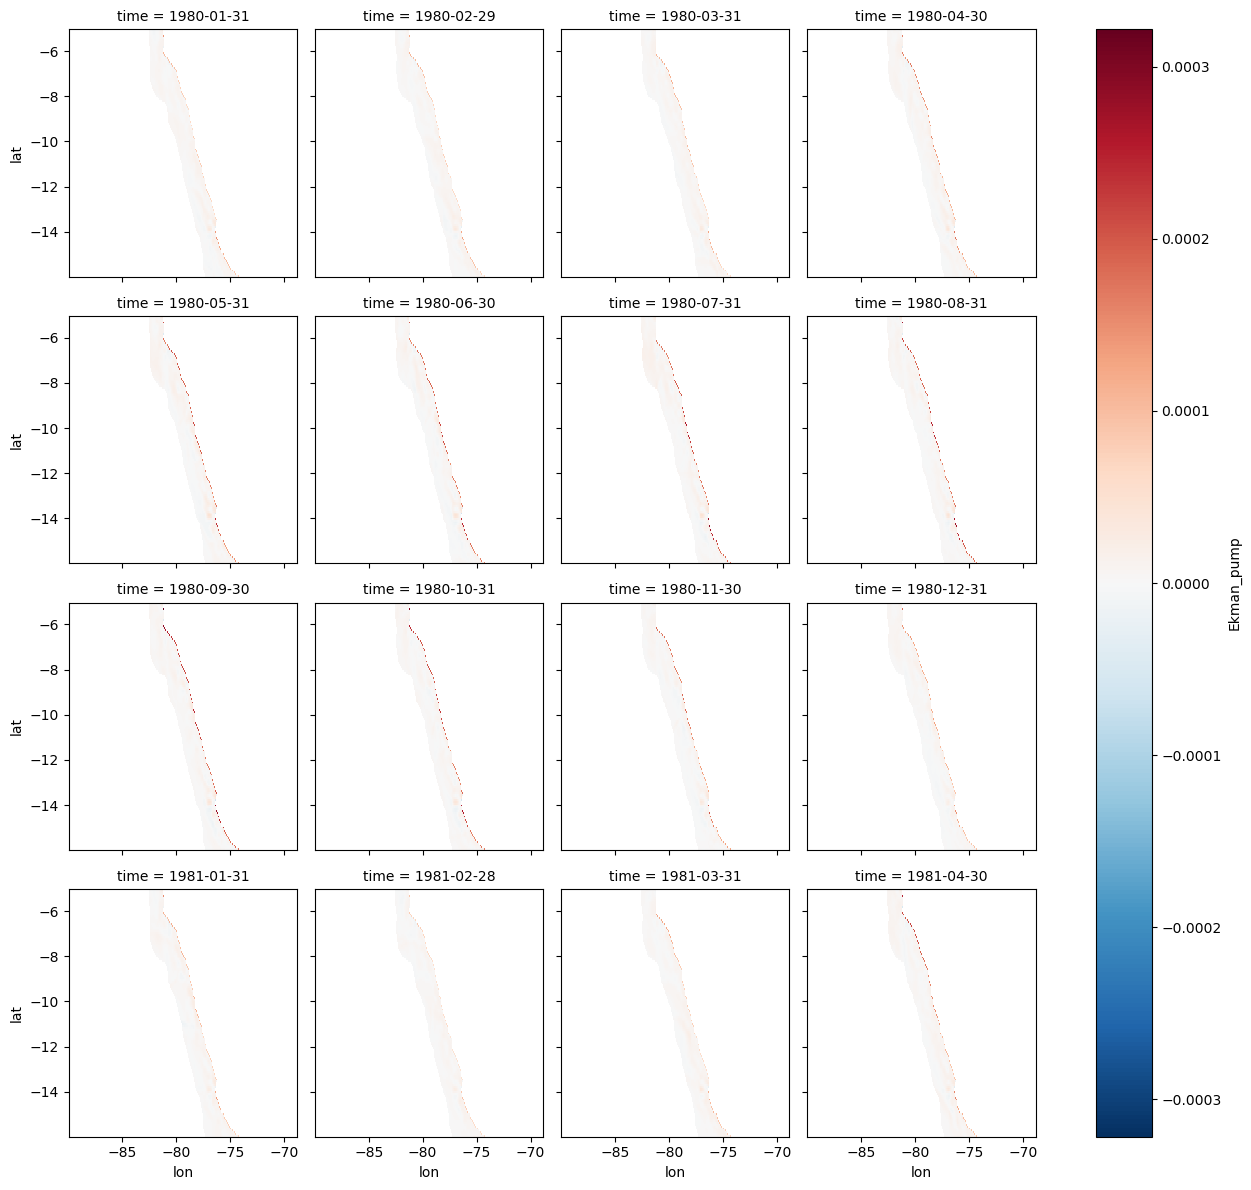

In [15]:
EK_pump.isel(time=slice(None, 16)).plot(
    x='lon', y='lat',  # Plot longitude on x-axis and latitude on y-axis
    col='time',        # Create subplots for each time step
    col_wrap=4         # Wrap subplots into 4 columns
)

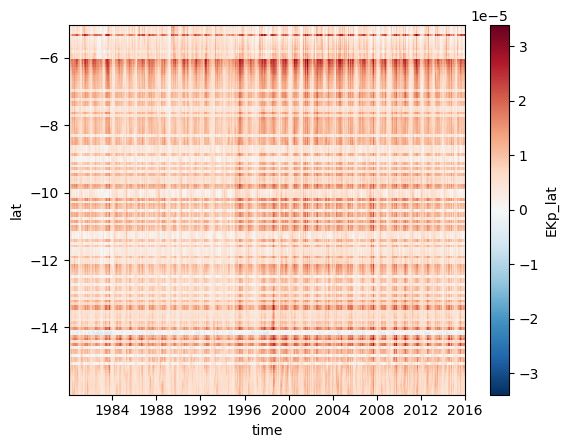

In [16]:
EK_ds['EKt_lat']=EK_ds['Ekman_transport'].mean(dim='lon', skipna=True)
EK_ds['EKp_lat']=EK_ds['Ekman_pump'].mean(dim='lon', skipna=True)

EK_ds['EKp_lat'].dropna(dim='lat').plot(y='lat')

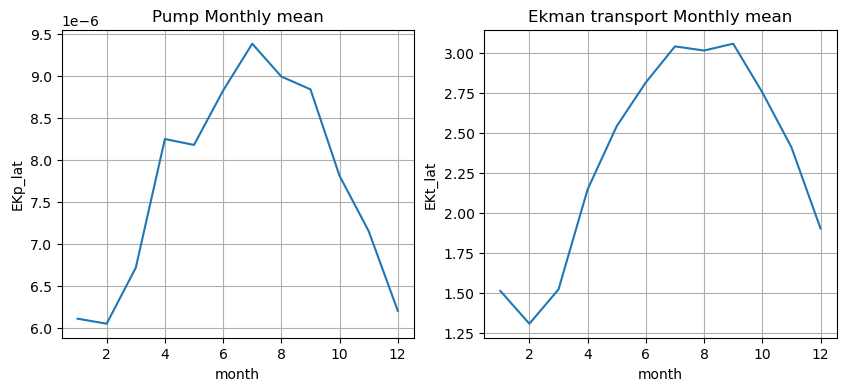

In [17]:
#----- Ekman pump
Pump_mmean = EK_ds['EKp_lat'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
Pump_anomaly = EK_ds['EKp_lat'].mean(dim='lat', skipna=True).groupby('time.month') - Pump_mmean
#---- Ekman transport 
Ekt_mmean = EK_ds['EKt_lat'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
Ekt_anomaly = EK_ds['EKt_lat'].mean(dim='lat', skipna=True).groupby('time.month') - Ekt_mmean

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

Pump_mmean.plot(ax=axes[0])
axes[0].set_title('Pump Monthly mean')
axes[0].grid(True)


Ekt_mmean.plot(ax=axes[1])
axes[1].set_title('Ekman transport Monthly mean')
axes[1].grid(True)

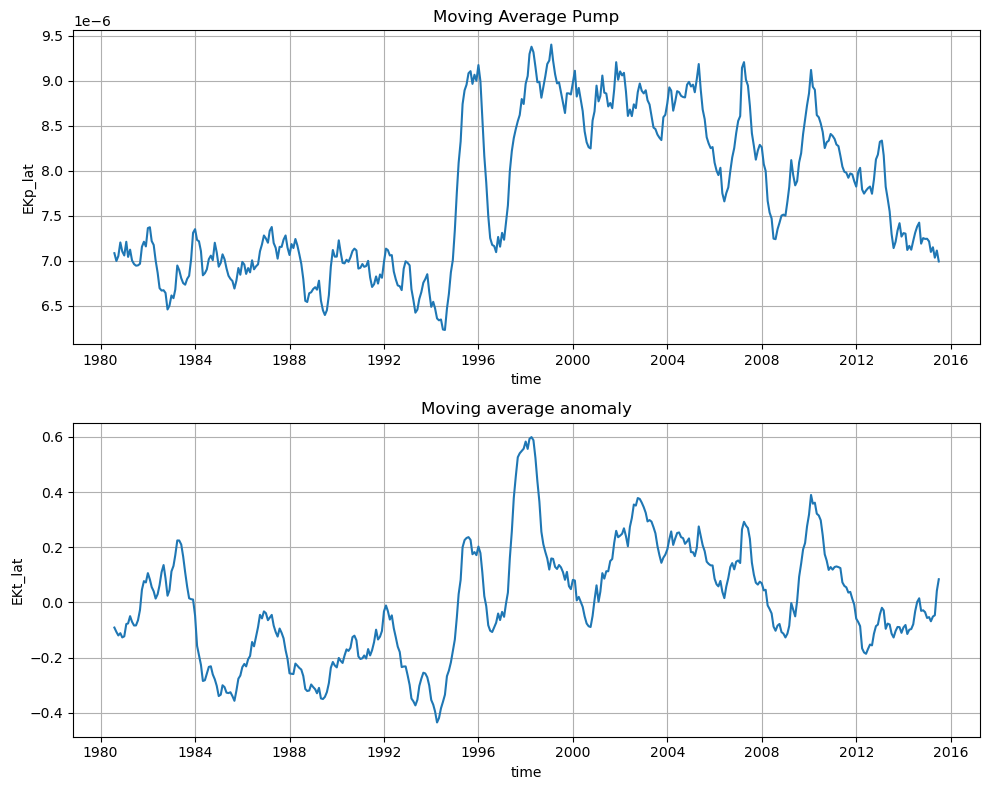

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

EK_ds['EKp_lat'].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean().plot(ax=axes[0])
axes[0].set_title('Moving Average Pump')
axes[0].grid(True)

Ekt_anomaly.rolling(time=13,center=True).mean().plot(ax=axes[1])
axes[1].set_title('Moving average anomaly')
axes[1].grid(True)

plt.tight_layout()
plt.show()

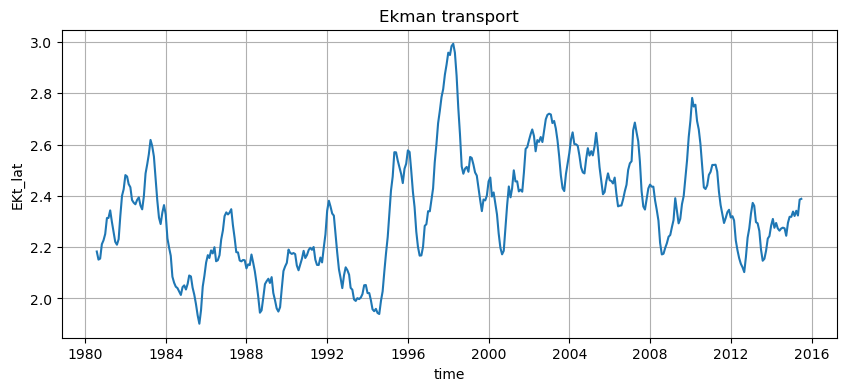

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

EK_ds['EKt_lat'].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean().plot(ax=ax)
ax.set_title('Ekman transport')
ax.grid(True)

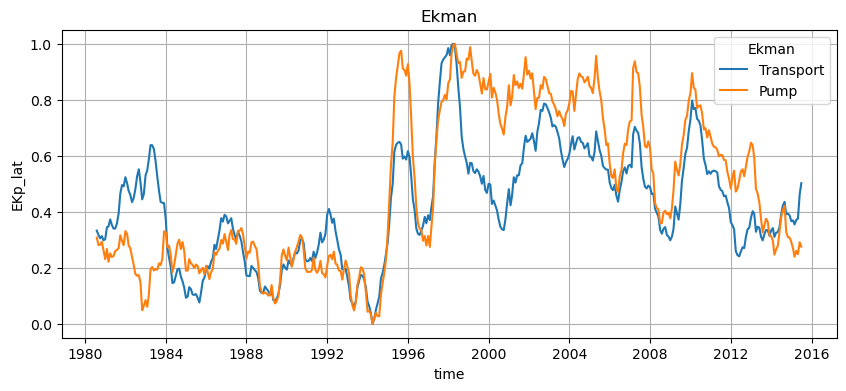

In [20]:
EKt_norm = normalize(Ekt_anomaly.rolling(time=13,center=True).mean())
Pump_norm = normalize(Pump_anomaly.rolling(time=13,center=True).mean())
# Pump_anomaly
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
EKt_norm.plot(ax=ax, label='Transport')
Pump_norm.plot(ax=ax, label='Pump')
ax.set_title('Ekman')
ax.grid(True)
ax.legend(title='Ekman', bbox_to_anchor=(1, 1))

### AV

In [21]:
AV_data = loadmat("../../NHCS/Processed/AV.mat")
print(AV_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'LAT', 'LON', 'W_amean', 'W_analytical', 'mask'])


In [22]:
Coastal_up = loadmat("../../NHCS/Processed/Coastal_upwelling.mat")

In [23]:
AV_data['W_analytical'].shape

(602, 542, 432)

In [24]:
AV_ds = xr.Dataset(
    data_vars={
        'AV': (("time", "lat","lon"), AV_data['W_analytical'].transpose(2, 1, 0)),
        'CUpwelling':(('time','lat','lon'),Coastal_up['WcMean'].transpose(2, 1, 0))
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

AV_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon         (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat         (lat) float64 4kB -33.0 -32.93 -32.86 ... 9.869 9.951 10.03
  * time        (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    AV          (time, lat, lon) float64 1GB 3.175e-07 4.708e-07 ... nan nan
    CUpwelling  (time, lat, lon) float64 1GB 2.64e-128 2.551e-128 ... nan nan

In [25]:
AV_ds['AV'] = AV_ds['AV'] * inshore_mask
AV_cut = AV_ds['AV'].where((AV_ds.lat >= -16) & (AV_ds.lat <= -5) & 
                  (AV_ds.lon >= -90) & (AV_ds.lon <= -65), drop=True)

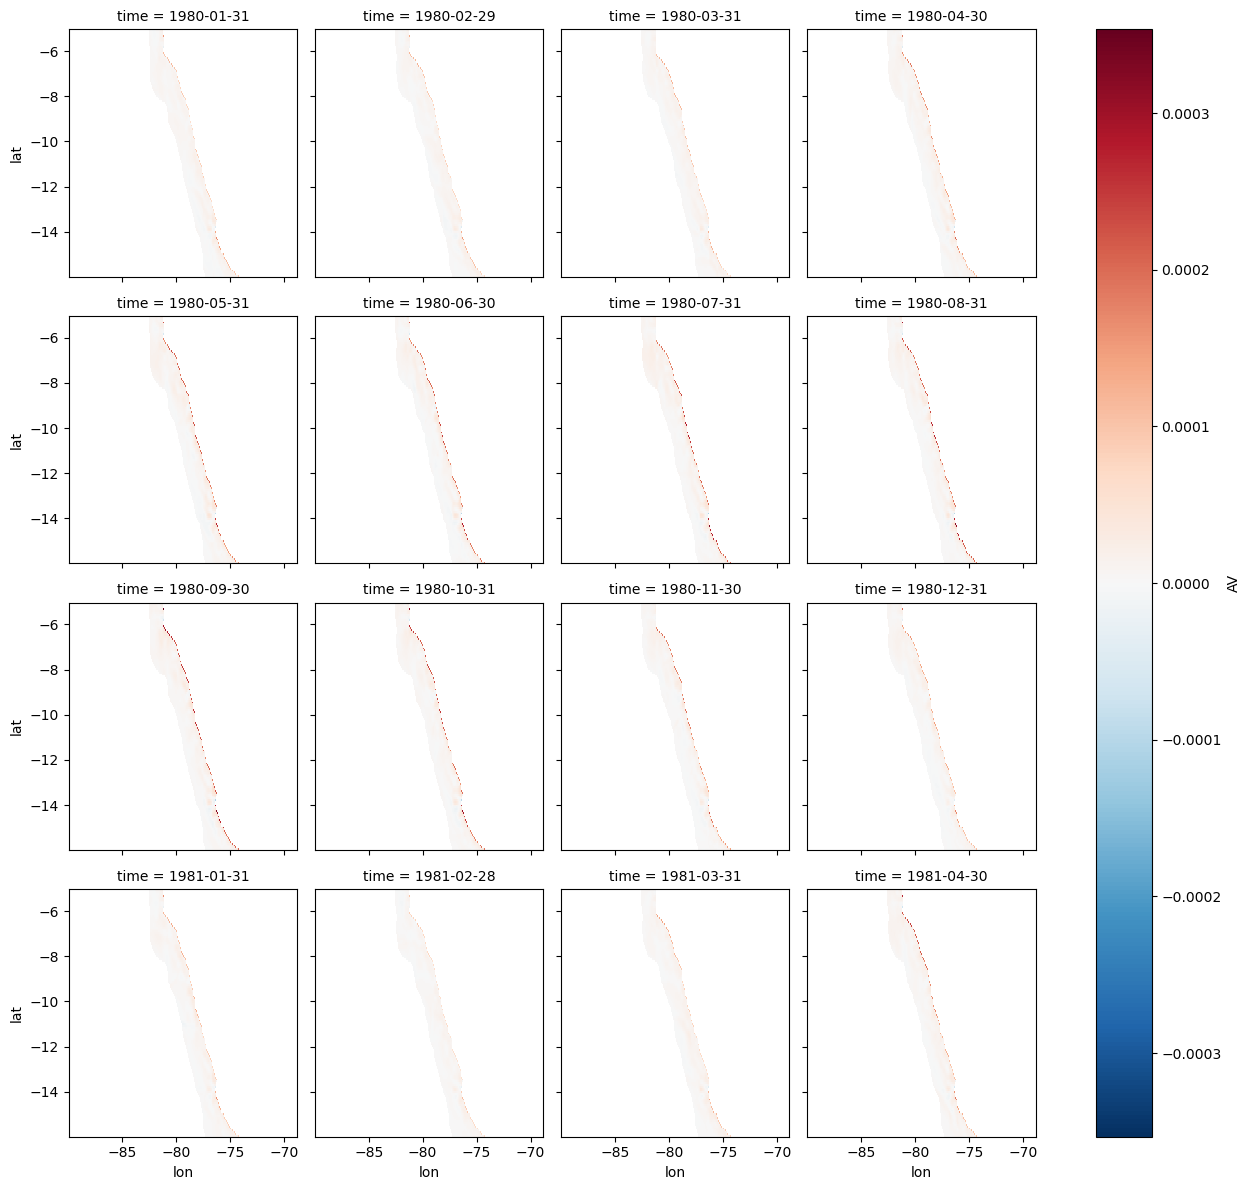

In [26]:
AV_cut.isel(time=slice(None, 16)).plot(
    x='lon', y='lat',  # Plot longitude on x-axis and latitude on y-axis
    col='time',        # Create subplots for each time step
    col_wrap=4         # Wrap subplots into 4 columns
)

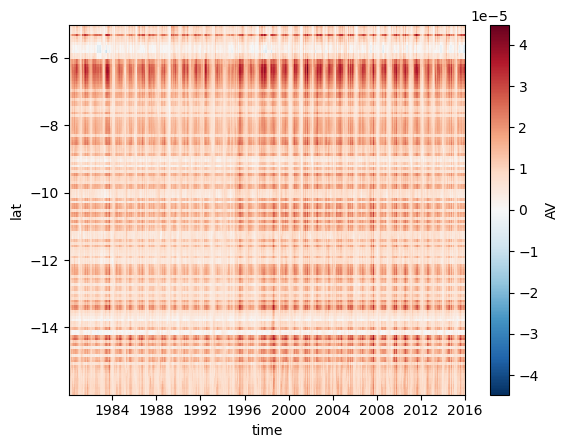

In [27]:
AV_ds['AV']=AV_cut.mean(dim='lon', skipna=True)

AV_ds['AV'].dropna(dim='lat').plot(y='lat')

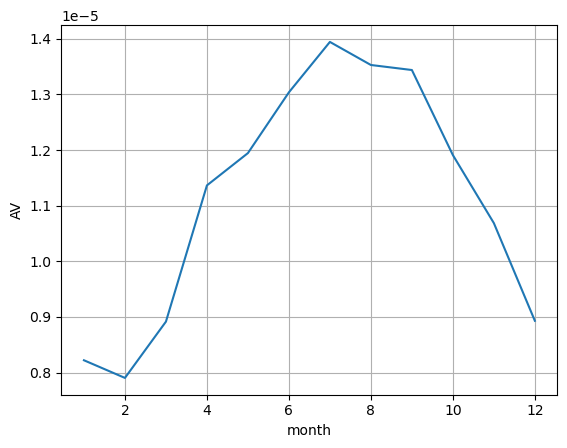

In [28]:
#----- Analytical velocity
AV_mmean = AV_ds['AV'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
AV_anomaly = AV_ds['AV'].mean(dim='lat', skipna=True).groupby('time.month') - AV_mmean

AV_mmean.plot()
plt.grid(True)

### HUI upwelling index

In [29]:
HUI_data = loadmat("../../NHCS/Processed/HUI_index.mat")
print(HUI_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'HUI', 'lati', 'Mean_HUI', 'HUI_index', 'HUI_lat'])


In [30]:
HUI_data['HUI'].shape

(602, 542, 432)

In [31]:
HUI_ds = xr.Dataset(
    data_vars={
        'HUI': (("time", "lat","lon"), HUI_data['HUI'].transpose(2, 1, 0)),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

HUI_ds

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    HUI      (time, lat, lon) float64 1GB 1.077e-06 1.266e-06 ... nan nan

In [32]:
HUI_ds['HUI'] = HUI_ds['HUI'] * inshore_mask
HUI_cut = HUI_ds['HUI'].where((HUI_ds.lat >= -16) & (HUI_ds.lat <= -5) & 
                  (HUI_ds.lon >= -90) & (HUI_ds.lon <= -65), drop=True)

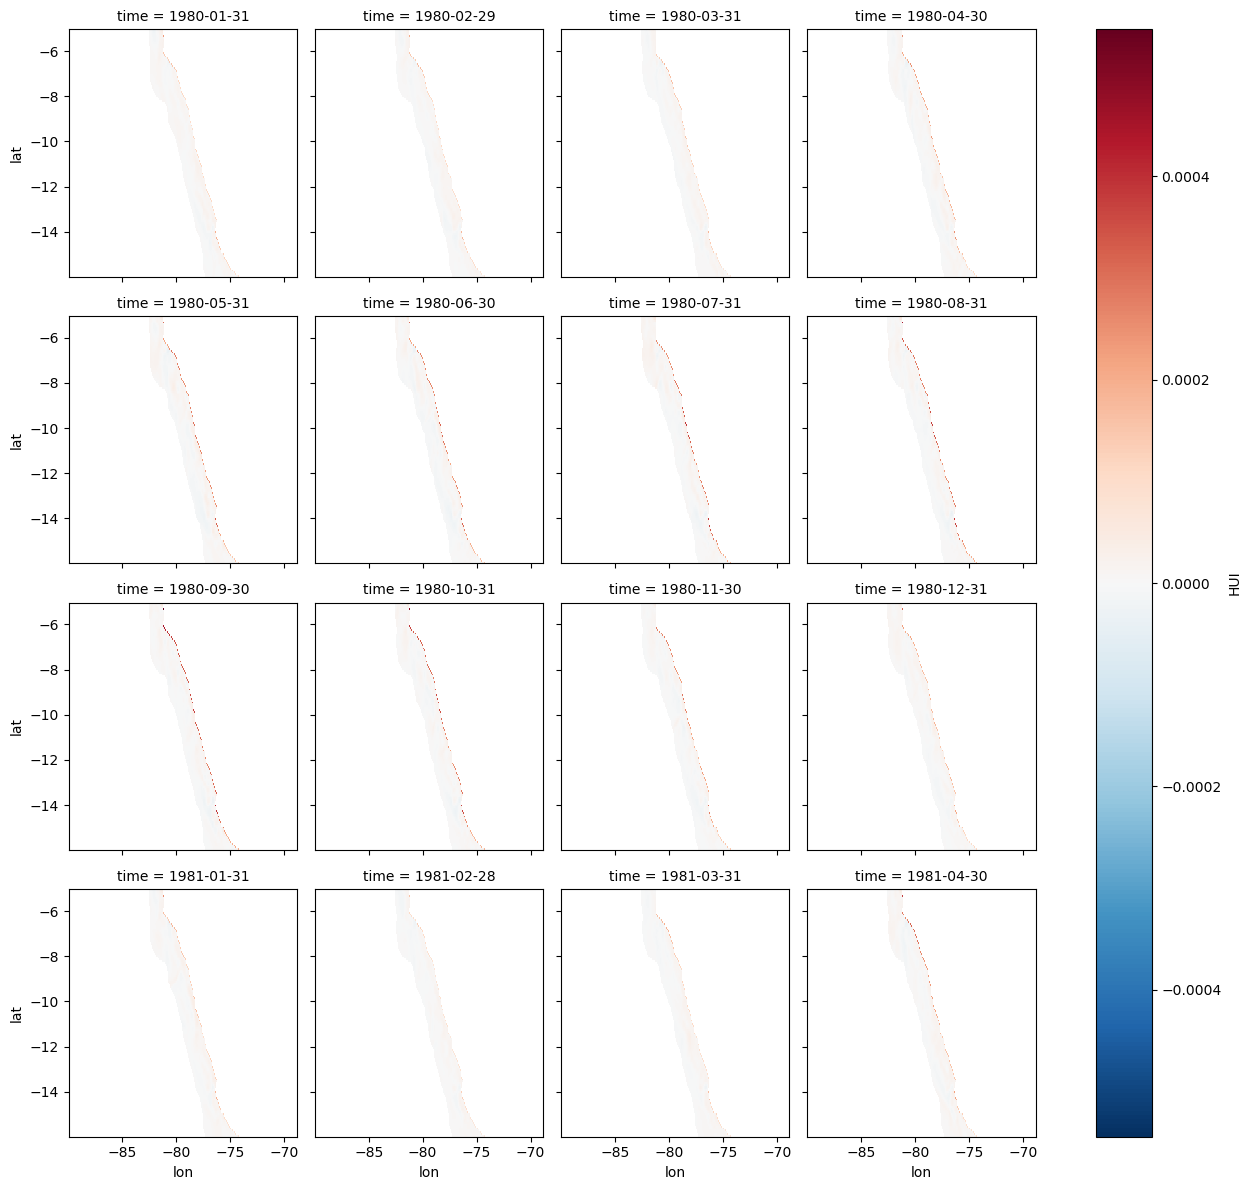

In [33]:
HUI_cut.isel(time=slice(None, 16)).plot(
    x='lon', y='lat',  # Plot longitude on x-axis and latitude on y-axis
    col='time',        # Create subplots for each time step
    col_wrap=4         # Wrap subplots into 4 columns
)

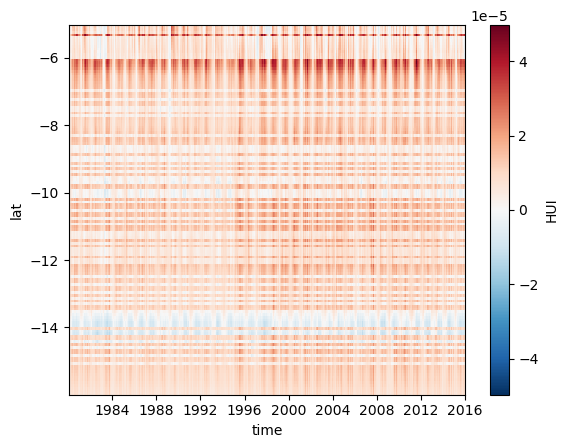

In [34]:
HUI_ds['HUI']=HUI_cut.mean(dim='lon', skipna=True)

HUI_ds['HUI'].dropna(dim='lat').plot(y='lat')

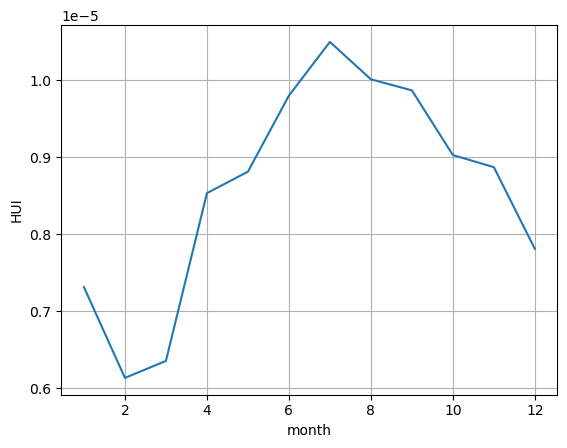

In [35]:
#----- HUI
HUI_mmean = HUI_ds['HUI'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
HUI_anomaly = HUI_ds['HUI'].mean(dim='lat', skipna=True).groupby('time.month') - HUI_mmean

HUI_mmean.plot()
plt.grid(True)

### CUTI

In [36]:
#Coastal_upwelling
CUTI_data = loadmat("../../NHCS/Processed/CUTI.mat")
print(CUTI_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'CUTI', 'CUTI_latitudinal', 'Mean_CUTI', 'latCUTI'])


In [37]:
CUTI_data['CUTI'].shape

(602, 542, 432)

In [38]:
CUTI_ds = xr.Dataset(
    data_vars={
        'CUTI': (("time", "lat","lon"), CUTI_data['CUTI'].transpose(2, 1, 0)),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

CUTI_ds

<xarray.Dataset> Size: 564MB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    CUTI     (time, lat, lon) float32 564MB 0.09788 0.102 0.1076 ... nan nan nan

In [39]:
CUTI_ds['CUTI'] = CUTI_ds['CUTI'] * inshore_mask
CUTI_cut = CUTI_ds['CUTI'].where((CUTI_ds.lat >= -16) & (CUTI_ds.lat <= -5) & 
                  (CUTI_ds.lon >= -90) & (CUTI_ds.lon <= -65), drop=True)

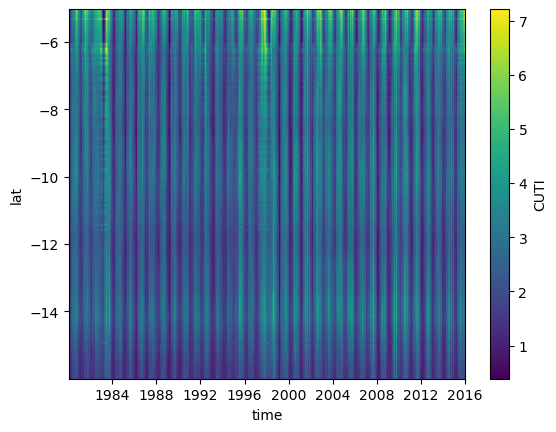

In [40]:
CUTI_ds['CUTI']=CUTI_cut.mean(dim='lon', skipna=True)*-1

CUTI_ds['CUTI'].dropna(dim='lat').plot(y='lat')

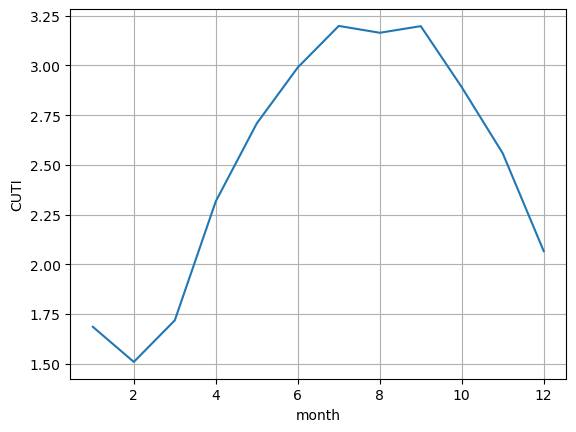

In [41]:
#----- CUTI
CUTI_mmean = CUTI_ds['CUTI'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
CUTI_anomaly = CUTI_ds['CUTI'].mean(dim='lat', skipna=True).groupby('time.month') - CUTI_mmean

CUTI_mmean.plot()
plt.grid(True)

### BEUTI

In [42]:
#Coastal_upwelling
BEUTI_data = loadmat("../../NHCS/Processed/BEUTI.mat")
print(BEUTI_data.keys())

BEUTI_ds = xr.Dataset(
    data_vars={
        'BEUTI': (("time", "lat","lon"), BEUTI_data['BEUTI'].transpose(2, 1, 0)),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

BEUTI_ds

dict_keys(['__header__', '__version__', '__globals__', 'BEUTI', 'Mean_BEUTI', 'latCUTI', 'BEUTI_latitudinal'])


<xarray.Dataset> Size: 564MB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    BEUTI    (time, lat, lon) float32 564MB 0.01551 0.0162 0.01768 ... nan nan

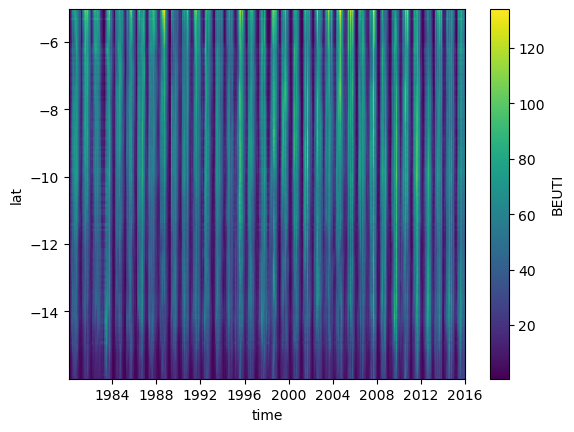

In [43]:
BEUTI_ds['BEUTI'] = BEUTI_ds['BEUTI'] * inshore_mask
BEUTI_cut = BEUTI_ds['BEUTI'].where((BEUTI_ds.lat >= -16) & (BEUTI_ds.lat <= -5) & 
                  (BEUTI_ds.lon >= -90) & (BEUTI_ds.lon <= -65), drop=True)

BEUTI_ds['BEUTI']=BEUTI_cut.mean(dim='lon', skipna=True)*-1

BEUTI_ds['BEUTI'].dropna(dim='lat').plot(y='lat')

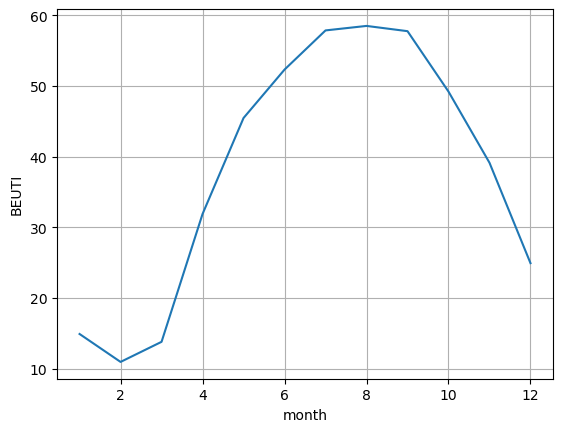

In [44]:
#----- BEUTI
BEUTI_mmean = BEUTI_ds['BEUTI'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
BEUTI_anomaly = BEUTI_ds['BEUTI'].mean(dim='lat', skipna=True).groupby('time.month') - BEUTI_mmean

BEUTI_mmean.plot()
plt.grid(True)

### BUI

In [45]:
#Coastal_upwelling
BUI_data = loadmat("../../NHCS/Processed/BUI.mat")
print(BUI_data.keys())

BUI_ds = xr.Dataset(
    data_vars={
        'BUI': (("time", "lat","lon"), BUI_data['BUI'].transpose(2, 1, 0)),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

BUI_ds

dict_keys(['__header__', '__version__', '__globals__', 'BUI', 'LAT', 'LON', 'UE', 'mask'])


<xarray.Dataset> Size: 1GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    BUI      (time, lat, lon) float64 1GB -0.03709 -0.03867 -0.04079 ... nan nan

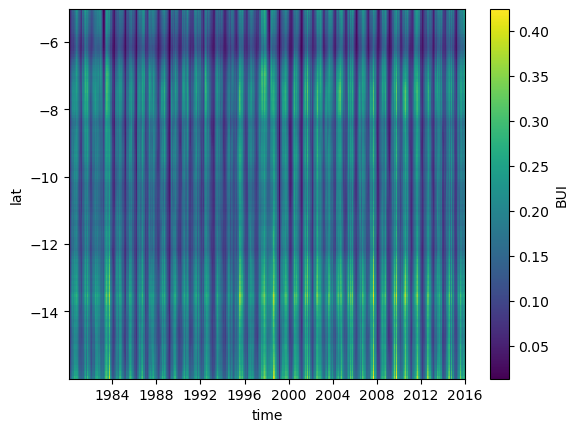

In [46]:
BUI_ds['BUI'] = BUI_ds['BUI'] * inshore_mask
BUI_cut = BUI_ds['BUI'].where((BUI_ds.lat >= -16) & (BUI_ds.lat <= -5) & 
                  (BUI_ds.lon >= -90) & (BUI_ds.lon <= -65), drop=True)

BUI_ds['BUI']=BUI_cut.mean(dim='lon', skipna=True)

BUI_ds['BUI'].dropna(dim='lat').plot(y='lat')

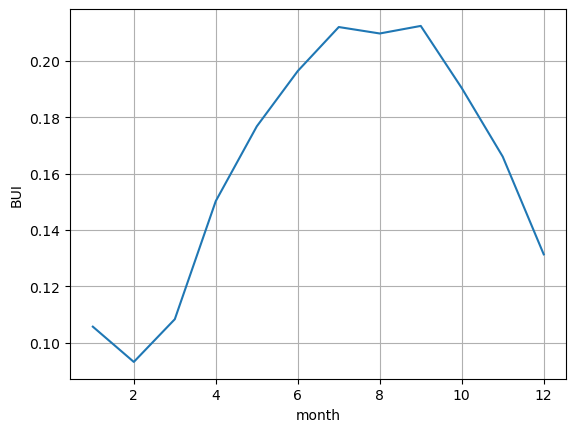

In [47]:
#----- BUI
BUI_mmean = BUI_ds['BUI'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
BUI_anomaly = BUI_ds['BUI'].mean(dim='lat', skipna=True).groupby('time.month') - BUI_mmean

BUI_mmean.plot()
plt.grid(True)

### W at the MLD

In [103]:
#Coastal_upwelling
WMLD_data = loadmat("../../NHCS/Processed/WMLD_MLD.mat")
print(WMLD_data.keys())

WMLD_ds_ = xr.Dataset(
    data_vars={
        'WMLD': (("time", "lat","lon"), WMLD_data['WMLD'].transpose(2, 0, 1)),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

WMLD_ds_

##------- Calculated MLD ------------ #
WMLD_dat = loadmat("../../NHCS/Processed/WMLD_MLD_cal.mat")
print(WMLD_dat.keys())

WMLD_cal = xr.Dataset(
    data_vars={
        'WMLD': (("time", "lat","lon"), WMLD_dat['WMLD'].transpose(2, 1, 0)),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

print(WMLD_ds)
print(WMLD_cal)


dict_keys(['__header__', '__version__', '__globals__', 'MLD', 'WMLD'])
dict_keys(['__header__', '__version__', '__globals__', 'MLD', 'WMLD'])
<xarray.Dataset> Size: 2MB
Dimensions:  (lon: 602, lat: 542, time: 432)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    WMLD     (time, lat) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
<xarray.Dataset> Size: 1GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    WMLD     (time, lat, lon) float64 1GB 4.613e-08 4.613e-08 ... nan nan


/tmp/ipykernel_1762042/418212304.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


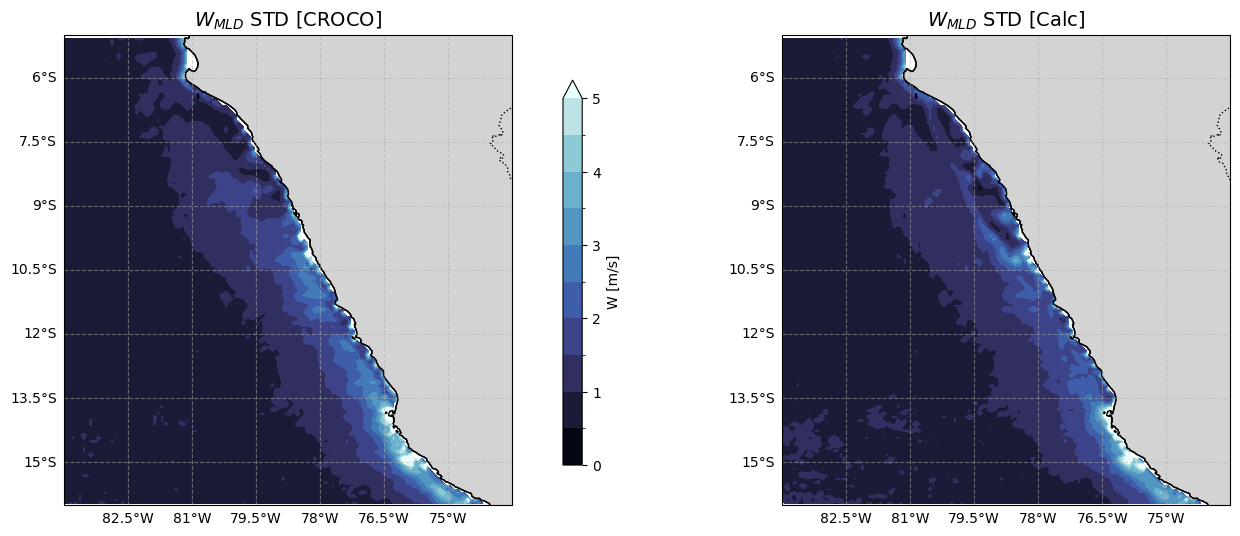

In [201]:
mask_rho = ds.mask_rho.values 
mask_nan = np.where(mask_rho, 1, np.nan)

std_Croco = WMLD_ds_.std(dim='time')*86400*mask_nan 

std_Calc = WMLD_cal.std(dim='time')*86400

fig, ax = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 5))

# Plot the first subplot (CROCO data)
cf1 = std_Croco.WMLD.sel(lon=slice(-84, -73.5), lat=slice(-16, -5)).plot.contourf(
    ax=ax[0],  # Plot on the first subplot
    transform=ccrs.PlateCarree(),  # Specify the transform for the data
    vmin=0, vmax=5,
    cmap=cm.ice,
    levels=np.arange(0, 5 + 0.5, 0.5),
    add_colorbar=False  # Disable the automatic colorbar
)

# Add map features to the first subplot
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
ax[0].add_feature(cfeature.COASTLINE)
ax[0].add_feature(cfeature.BORDERS, linestyle=':')

# Set the title for the first subplot
ax[0].set_title('$W_{MLD}$ STD [CROCO]', fontsize=14)

# Add gridlines and labels to the first subplot
gl1 = ax[0].gridlines(draw_labels=True, linestyle='--', alpha=0.5, crs=ccrs.PlateCarree())
gl1.top_labels = False  # Disable top labels
gl1.right_labels = False  # Disable right labels

# Plot the second subplot (Calc data)
cf2 = std_Calc.WMLD.sel(lon=slice(-84, -73.5), lat=slice(-16, -5)).plot.contourf(
    ax=ax[1],  # Plot on the second subplot
    transform=ccrs.PlateCarree(),  # Specify the transform for the data
    vmin=0, vmax=5,
    cmap=cm.ice,
    levels=np.arange(0, 5 + 0.5, 0.5),
    add_colorbar=False  # Disable the automatic colorbar
)

# Add map features to the second subplot
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
ax[1].add_feature(cfeature.COASTLINE)
ax[1].add_feature(cfeature.BORDERS, linestyle=':')

# Set the title for the second subplot
ax[1].set_title('$W_{MLD}$ STD [Calc]', fontsize=14)

# Add gridlines and labels to the second subplot
gl2 = ax[1].gridlines(draw_labels=True, linestyle='--', alpha=0.5, crs=ccrs.PlateCarree())
gl2.top_labels = False  # Disable top labels
gl2.right_labels = False  # Disable right labels

# Add a single colorbar for both subplots
cbar = plt.colorbar(cf1, orientation='vertical', pad=0.02, fraction=0.5, ax=ax)
cbar.set_label('W [m/s]')

# Set the extent for both subplots
for a in ax:
    a.set_extent([-84, -73.5, -16, -5], crs=ccrs.PlateCarree())

# Adjust layout and show the plot
# plt.savefig('Figures/W_STD'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [186]:
mean_WMLD = WMLD_ds_.WMLD.sel(lat=slice(-16, -5), lon=slice(-84, -73.5)).mean(dim='time',skipna=True)
mean_WMLD = xr.where(mean_WMLD == 0, np.nan, mean_WMLD)

mean_WMLD_cal = WMLD_cal.WMLD.sel(lat=slice(-16, -5), lon=slice(-84, -73.5)).mean(dim='time',skipna=True)
mean_WMLD_cal = xr.where(mean_WMLD_cal == 0, np.nan, mean_WMLD)

/opt/conda/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


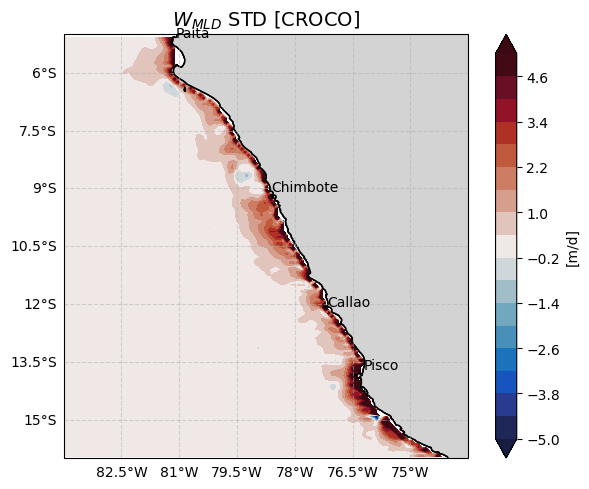

In [210]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm 


# Extract latitude and longitude
lat = mean_WMLD.lat.values
lon = mean_WMLD.lon.values

# Create a meshgrid for longitude and latitude
loni, lati = np.meshgrid(lon, lat)
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
# Create a figure and axis with a cartopy projection
fig, ax = plt.subplots(ncols=1, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 5))
# Plot the data using contourf
cs=plt.contourf(loni, lati, mean_WMLD*86400, cmap=cm.balance,norm=norm, extend='both',
                levels=np.arange(-5, 5+0.6, 0.6))

for key in Puertos:
  x,y = Puertos[key][1],Puertos[key][0]
  plt.text(x,y,key,fontsize=10)
    
# ax.clim(-2,2)
# Add a colorbar
cbar = plt.colorbar(cs, orientation='vertical', pad=0.02, fraction=0.1)
cbar.set_label('[m/d]')

# Add land feature with grey filler color
land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='10m',
    facecolor='lightgrey',  # Set the land fill color to grey
    edgecolor='black'  # Set the coastline color to black
)

# Add map features
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE,facecolor='grey')
ax.add_feature(cfeature.LAND, edgecolor='black')
# ax.add_feature(cfeature.OCEAN)

# Add gridlines and labels
# ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
ax.set_title('$W_{MLD}$ STD [CROCO]', fontsize=14)

gl2 = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, crs=ccrs.PlateCarree())
gl2.top_labels = False  # Disable top labels
gl2.right_labels = False  # Disable right labels

# Set extent to focus on the region of interest
ax.set_extent([-84, -73.5, -16, -5], crs=ccrs.PlateCarree())

# ax.coastlines(resolution='10km')
# plt.savefig('Figures/W_MLD_LTM'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

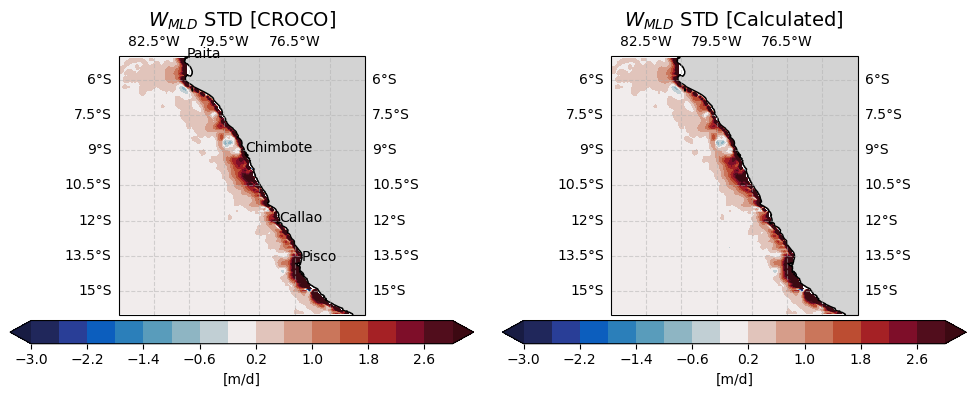

In [203]:

norm = TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)
# Create a figure and axis with a cartopy projection
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,4), subplot_kw=dict(projection=ccrs.PlateCarree()))


# Plot the data using contourf
cs=ax[0].contourf(loni, lati, mean_WMLD*86400, cmap=cm.balance,norm=norm, extend='both',
                levels=np.arange(-3, 3+0.4, 0.4))

for key in Puertos:
  x,y = Puertos[key][1],Puertos[key][0]
  ax[0].text(x,y,key,fontsize=10)
    
# ax.clim(-2,2)
# Add a colorbar
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.02, fraction=0.1,ax=ax[0])
cbar.set_label('[m/d]')

# Add land feature with grey filler color
land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='10m',
    facecolor='lightgrey',  # Set the land fill color to grey
    edgecolor='black'  # Set the coastline color to black
)

# Add map features
ax[0].add_feature(land)
# ax.add_feature(cfeature.COASTLINE,facecolor='grey')
ax[0].add_feature(cfeature.LAND, edgecolor='black')
# ax.add_feature(cfeature.OCEAN)

# Add gridlines and labels
ax[0].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
ax[0].set_title('W at MLD', fontsize=14)

# Set extent to focus on the region of interest
ax[0].set_extent([-84, -73.5, -16, -5], crs=ccrs.PlateCarree())

# ax.coastlines(resolution='10km')
# plt.savefig('Figures/W_MLD_LTM'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
# Show the plot

##---- Wcalculated

# Plot the data using contourf
cs=ax[1].contourf(loni, lati, mean_WMLD_cal*86400, cmap=cm.balance,norm=norm, extend='both',
                levels=np.arange(-3, 3+0.4, 0.4))

# for key in Puertos:
#   x,y = Puertos[key][1],Puertos[key][1]
#   ax[1].text(x,y,key,fontsize=10)
    
# ax.clim(-2,2)
# Add a colorbar
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.02, fraction=0.1,ax=ax[1])
cbar.set_label('[m/d]')

# Add land feature with grey filler color
land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='10m',
    facecolor='lightgrey',  # Set the land fill color to grey
    edgecolor='black'  # Set the coastline color to black
)

# Add map features
ax[1].add_feature(land)
# ax.add_feature(cfeature.COASTLINE,facecolor='grey')
ax[1].add_feature(cfeature.LAND, edgecolor='black')
# ax.add_feature(cfeature.OCEAN)

# Add gridlines and labels
ax[1].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
ax[1].set_title('W at MLD', fontsize=14)

# Set extent to focus on the region of interest
ax[1].set_extent([-84, -73.5, -16, -5], crs=ccrs.PlateCarree())

ax[0].set_title('$W_{MLD}$ STD [CROCO]', fontsize=14)
ax[1].set_title('$W_{MLD}$ STD [Calculated]', fontsize=14)
# ax.coastlines(resolution='10km')
# plt.savefig('Figures/Calc_W_MLD_LTM'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()


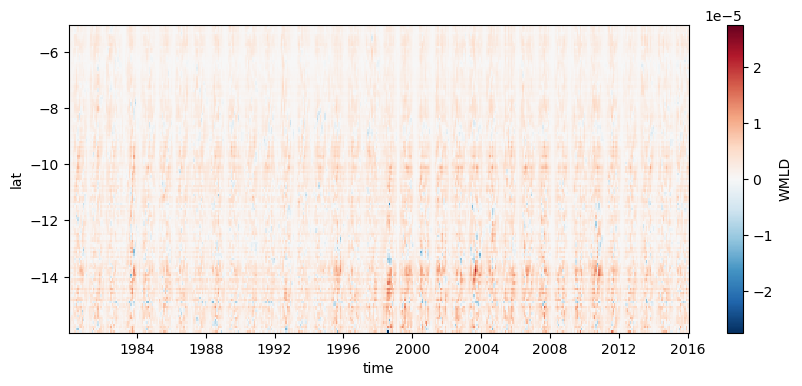

In [78]:
WMLD_ds['WMLD'] = WMLD_ds_['WMLD'] * inshore_mask
WMLD_cut = WMLD_ds['WMLD'].where((WMLD_ds.lat >= -16) & (WMLD_ds.lat <= -5) & 
                  (WMLD_ds.lon >= -90) & (WMLD_ds.lon <= -65), drop=True)

WMLD_ds['WMLD']=WMLD_cut.mean(dim='lon', skipna=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
WMLD_ds['WMLD'].dropna(dim='lat').plot(ax=ax,y='lat')

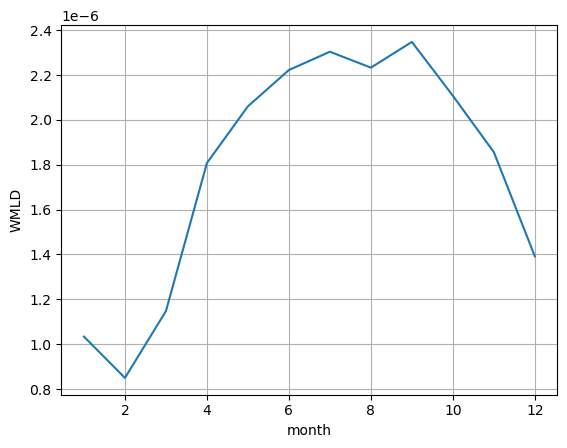

In [79]:
#----- WMLD
WMLD_mmean = WMLD_ds['WMLD'].mean(dim='lat',skipna=True).groupby('time.month').mean(dim='time')
WMLD_anomaly = WMLD_ds['WMLD'].mean(dim='lat', skipna=True).groupby('time.month') - WMLD_mmean

WMLD_mmean.plot()
plt.grid(True)

## Latitudinal Mean

In [98]:
WMLD_lat = WMLD_ds_['WMLD'] * inshore_mask
# WMLD_lat
CUI_ds

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,7))
# WMLD_lat.mean(dim='lon').sel(lat=slice(-20,0)).mean(dim='time').rolling(lat=13,center=True).mean().plot(ax=ax,y='lat')
# plt.grid()
# plt.ylim([-16, -5])

<xarray.DataArray 'CUI_cc' (time: 432, lat: 185)> Size: 320kB
array([[1.0513515 , 1.0935459 , 1.1349678 , ..., 3.044176  , 2.9407597 ,
        2.855959  ],
       [0.8243084 , 0.73539925, 0.6374855 , ..., 1.8800182 , 1.8974552 ,
        1.9528027 ],
       [0.22629738, 0.5072441 , 0.7329922 , ..., 2.8429527 , 2.7723064 ,
        2.8034554 ],
       ...,
       [0.97706604, 1.0218201 , 1.0204983 , ..., 1.2903767 , 1.3467522 ,
        1.3760109 ],
       [1.3990173 , 1.502945  , 1.608551  , ..., 0.064394  , 0.16672325,
        0.2874241 ],
       [2.415516  , 2.4410248 , 2.4481964 , ..., 1.7548542 , 1.7767258 ,
        1.8258553 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
  * lat      (lat) float64 1kB -19.99 -19.92 -19.84 ... -5.242 -5.159 -5.076

(-16.0, -5.0)

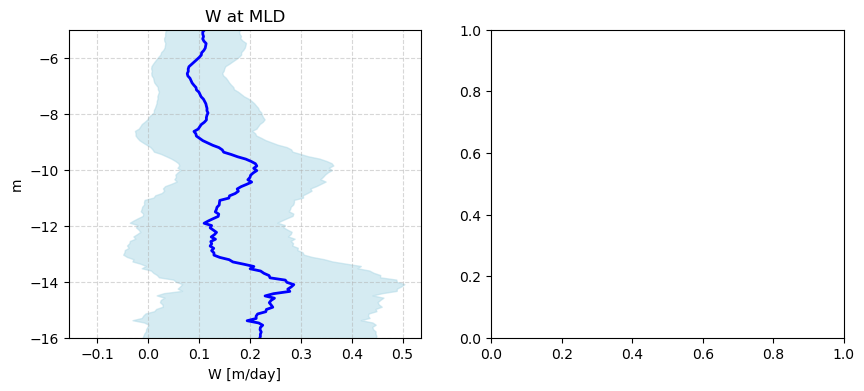

In [96]:
# wmld_lat = WMLD_lat.mean(dim='lon').sel(lat=slice(-20,0)).mean(dim='time').rolling(lat=13,center=True).mean() 
wmld_lat = WMLD_lat.mean(dim='lon').sel(lat=slice(-20,0)) * 86400

w_mean_ = wmld_lat.mean(dim='time').rolling(lat=13,center=True).mean()  # Mean across time for each depth
w_std_ = wmld_lat.std(dim='time').rolling(lat=13,center=True).mean()    # Standard deviation across time for each depth


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].plot(w_mean_, w_mean_['lat'], color='blue', label='Mean', linewidth=2)
axes[0].fill_betweenx(w_mean_['lat'], w_mean_ - w_std_, w_mean_ + w_std_, 
                  color='lightblue', alpha=0.5, label='±1 SD')
axes[0].set_title('W at MLD')
axes[0].grid(linestyle='--', alpha=0.5)
axes[0].set_xlabel('W [m/day]')
axes[0].set_ylabel('m')
axes[0].set_ylim([-16, -5])
# axes[0].axvline(0, color='black', linestyle='--', linewidth=1)

## Seasonality 

In [53]:
time = np.linspace(1,12,12)

UI_dic_real = {
    # 'time':time,
    'WMLD':WMLD_mmean.values,
    'AV':AV_mmean.values,
    'CUI':CUI_mmean.values,
    'Pump':Pump_mmean.values,
    'EkT':Ekt_mmean.values,
    'HUI':HUI_mmean.values,
    'CUTI':CUTI_mmean.values,
    'BEUTI':BEUTI_mmean.values,
    'BUI':BUI_mmean.values
}

season_mmonth = pd.DataFrame(UI_dic_real)
season_mmonth

WMLD        AV       CUI      Pump       EkT       HUI      CUTI  \
0   1.033847e-06  0.000008  2.132665  0.000006  1.513790  0.000007  1.684909   
1   8.495813e-07  0.000008  2.536556  0.000006  1.308210  0.000006  1.508153   
2   1.147615e-06  0.000009  3.135864  0.000007  1.522805  0.000006  1.717523   
3   1.807793e-06  0.000011  4.375791  0.000008  2.149114  0.000009  2.316457   
4   2.060622e-06  0.000012  4.203512  0.000008  2.544639  0.000009  2.708572   
5   2.222580e-06  0.000013  3.297929  0.000009  2.818229  0.000010  2.990030   
6   2.303993e-06  0.000014  2.504006  0.000009  3.043630  0.000010  3.199037   
7   2.233168e-06  0.000014  2.055296  0.000009  3.017670  0.000010  3.164557   
8   2.347815e-06  0.000013  1.748442  0.000009  3.060307  0.000010  3.197953   
9   2.107651e-06  0.000012  1.682813  0.000008  2.756226  0.000009  2.890720   
10  1.856211e-06  0.000011  1.658608  0.000007  2.412675  0.000009  2.557933   
11  1.391658e-06  0.000009  1.704660  0.000006  1.904307  0.000008  2.065564   

        BEUTI       BUI  
0   14.898421  0.105636  
1   10.945874  0.093104  
2   13.790113  0.108284  
3   31.879053  0.150282  
4   45.461288  0.176814  
5   52.310025  0.196485  
6   57.853876  0.212108  
7   58.489742  0.209818  
8   57.746792  0.212504  
9   49.195787  0.190427  
10  39.126280  0.166049  
11  24.921089  0.131323

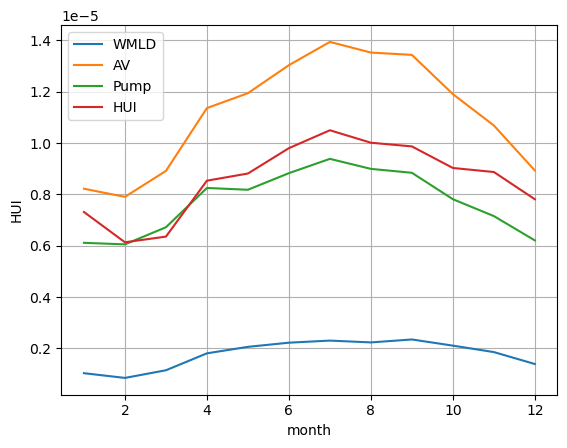

In [54]:
WMLD_mmean.plot(label='WMLD')
AV_mmean.plot(label='AV')
Pump_mmean.plot(label='Pump')
HUI_mmean.plot(label='HUI')
plt.grid(True)
plt.legend()

In [55]:
## Normalize the Indices
## Indices 
WMLD_mmonth_normal = normalize(WMLD_mmean)
AV_mmonth_normal = normalize(AV_mmean)
CUI_mmonth_normal=normalize(CUI_mmean)
Pump_mmonth_normal=normalize(Pump_mmean)
Ekt_mmonth_normal=normalize(Ekt_mmean)
HUI_mmonth_normal=normalize(HUI_mmean)
CUTI_mmonth_normal=normalize(CUTI_mmean)
BEUTI_mmonth_normal=normalize(BEUTI_mmean)
BUI_mmonth_normal=normalize(BUI_mmean)

In [56]:
time = np.linspace(1,12,12)

UI_dic = {
    # 'time':time,
    'WMLD':WMLD_mmonth_normal.values,
    'AV':AV_mmonth_normal.values,
    'CUI':CUI_mmonth_normal.values,
    # 'Pump':Pump_mmonth_normal.values,
    'EkT':Ekt_mmonth_normal.values,
    'HUI':HUI_mmonth_normal.values,
    'CUTI':CUTI_mmonth_normal.values,
    'BEUTI':BEUTI_mmonth_normal.values,
    'BUI':BUI_mmonth_normal.values
}

normalized_mmonth = pd.DataFrame(UI_dic)
normalized_mmonth


WMLD        AV       CUI       EkT       HUI      CUTI     BEUTI  \
0   0.122989  0.052555  0.174466  0.117334  0.270283  0.104534  0.083135   
1   0.000000  0.000000  0.323109  0.000000  0.000000  0.000000  0.000000   
2   0.198924  0.167524  0.543672  0.122479  0.050640  0.123822  0.059823   
3   0.639561  0.572997  1.000000  0.479941  0.549918  0.478036  0.440292   
4   0.808312  0.669124  0.936597  0.705685  0.613838  0.709935  0.725970   
5   0.916412  0.850010  0.603316  0.861835  0.840238  0.876392  0.870021   
6   0.970751  1.000000  0.311130  0.990482  1.000000  1.000000  0.986626   
7   0.923478  0.931342  0.145992  0.975665  0.888759  0.979608  1.000000   
8   1.000000  0.916378  0.033061  1.000000  0.855836  0.999358  0.984373   
9   0.839702  0.663247  0.008908  0.826448  0.663297  0.817659  0.804518   
10  0.671877  0.460736  0.000000  0.630368  0.627260  0.620847  0.592724   
11  0.361810  0.170058  0.016948  0.340219  0.384047  0.329657  0.293944   

         BUI  
0   0.104952  
1   0.000000  
2   0.127129  
3   0.478879  
4   0.701086  
5   0.865836  
6   0.996682  
7   0.977502  
8   1.000000  
9   0.815100  
10  0.610927  
11  0.320093

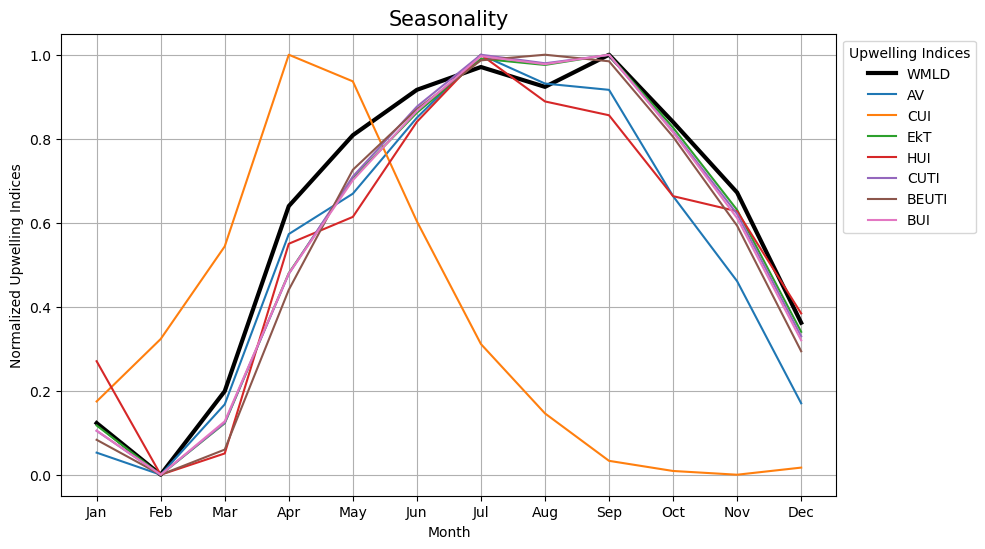

In [57]:
import matplotlib.pyplot as plt
normalized_df=normalized_mmonth
# Assuming normalized_df.index contains integer values representing months (1 for January, 2 for February, etc.)

# Create the figure
plt.figure(figsize=(10, 6))

# Plot the first column with a solid black line
first_column = normalized_df.columns[0]
plt.plot(normalized_df.index, normalized_df[first_column], label=first_column, color='black', linestyle='-', linewidth=3)

# Iterate over the remaining columns and plot each variable
for column in normalized_df.columns[1:]:
    plt.plot(normalized_df.index, normalized_df[column], label=column)

# Manually specify the positions and labels for the x-axis ticks
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(normalized_df.index, months)

plt.xlabel('Month')
plt.ylabel('Normalized Upwelling Indices')
plt.title('Seasonality',fontsize=15)
plt.legend(title='Upwelling Indices', bbox_to_anchor=(1, 1))
plt.grid(True)

# plt.savefig('Clim_normalized'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()

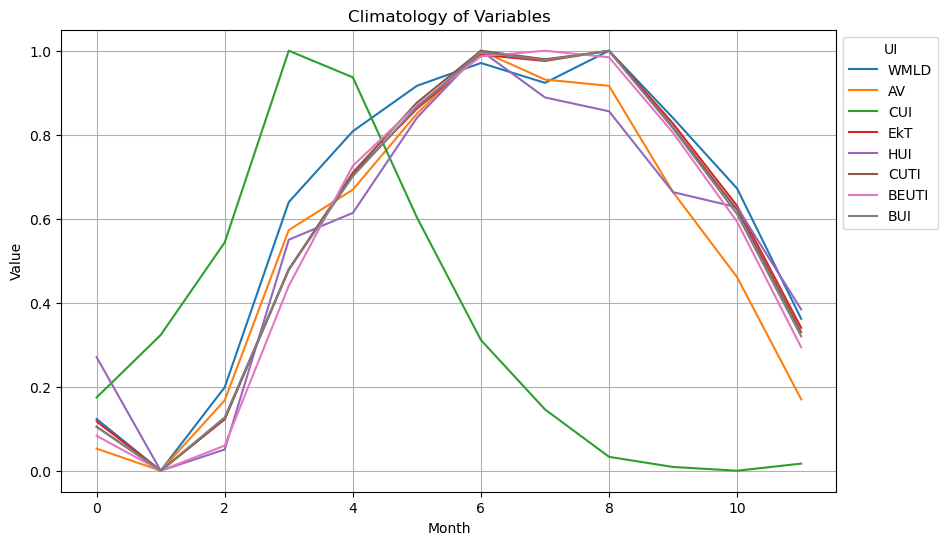

In [58]:
import matplotlib.pyplot as plt

# Assuming 'climatology' is your DataFrame containing the climatology data
plt.figure(figsize=(10, 6))

# Iterate over columns and plot each variable
for column in normalized_mmonth.columns:
    plt.plot(normalized_mmonth.index, normalized_mmonth[column], label=column)

plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Climatology of Variables')
plt.legend(title='UI', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Interannual variability

In [59]:
## gathering the monthly mean 
time = pd.date_range(start="1980-01",end="2016-01",freq='M')

UI_monthly = {
    # 'time':time,
    'WMLD':WMLD_ds['WMLD'].mean(dim='lat', skipna=True).values,
    'AV':AV_ds['AV'].mean(dim='lat',skipna=True).values,
    'CUI':CUI_cut.mean(dim='lat', skipna=True).values,
    'Pump':EK_ds['EKp_lat'].mean(dim='lat', skipna=True).values,
    'EkT':EK_ds['EKt_lat'].mean(dim='lat', skipna=True).values,
    'HUI':HUI_ds['HUI'].mean(dim='lat',skipna=True).values,
    'CUTI':CUTI_ds['CUTI'].mean(dim='lat', skipna=True).values,
    'BEUTI':BEUTI_ds['BEUTI'].mean(dim='lat', skipna=True).values,
    'BUI':BUI_ds['BUI'].mean(dim='lat', skipna=True).values
}



UI_monthly_inter = pd.DataFrame(UI_monthly)
UI_monthly_inter.index = time

# Extract month and year from the time index
UI_monthly_inter['month'] = UI_monthly_inter.index.month
UI_monthly_inter['year'] = UI_monthly_inter.index.year

UI_monthly_inter

/tmp/ipykernel_1503244/1819804267.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time = pd.date_range(start="1980-01",end="2016-01",freq='M')


WMLD        AV       CUI      Pump       EkT       HUI  \
1980-01-31  9.975206e-07  0.000008  2.721126  0.000006  1.401106  0.000007   
1980-02-29  8.561944e-07  0.000008  3.058046  0.000006  1.310622  0.000006   
1980-03-31  8.869318e-07  0.000008  3.572625  0.000006  1.425859  0.000006   
1980-04-30  1.394605e-06  0.000010  3.700169  0.000008  2.001281  0.000008   
1980-05-31  2.044053e-06  0.000012  4.336253  0.000008  2.484240  0.000009   
...                  ...       ...       ...       ...       ...       ...   
2015-08-31  1.889944e-06  0.000013  2.203553  0.000008  3.053928  0.000009   
2015-09-30  1.675102e-06  0.000011  1.577053  0.000007  2.712000  0.000007   
2015-10-31  1.798138e-06  0.000012  2.020351  0.000008  2.978965  0.000009   
2015-11-30  1.587350e-06  0.000011  1.408531  0.000007  3.034904  0.000007   
2015-12-31  1.727923e-06  0.000010  1.406037  0.000006  2.581579  0.000007   

                CUTI      BEUTI       BUI  month  year  
1980-01-31  1.566118  14.161852  0.098005      1  1980  
1980-02-29  1.500137  11.747133  0.091804      2  1980  
1980-03-31  1.644031  13.110275  0.100329      3  1980  
1980-04-30  2.228052  25.296039  0.140134      4  1980  
1980-05-31  2.692560  43.246891  0.174081      5  1980  
...              ...        ...       ...    ...   ...  
2015-08-31  3.199478  62.446427  0.210042      8  2015  
2015-09-30  2.884841  50.073820  0.185533      9  2015  
2015-10-31  3.165839  53.413097  0.204305     10  2015  
2015-11-30  3.258761  47.583720  0.205277     11  2015  
2015-12-31  2.808212  38.363138  0.175765     12  2015  

[432 rows x 11 columns]

In [90]:
magnitud = pd.DataFrame(['m/s','m/s','[°C]','m/s','m2/s','m/s','m2/s','mmol m/s','m2/s'])
magnitud.index = indices
magnitud

0
WMLD        m/s
AV          m/s
CUI        [°C]
Pump        m/s
EkT        m2/s
HUI         m/s
CUTI       m2/s
BEUTI  mmol m/s
BUI        m2/s

/tmp/ipykernel_1503244/806948868.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1503244/806948868.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].set_ylabel(magnitud[0][i])
/tmp/ipykernel_1503244/806948868.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1503244/806948868.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].set_ylabel(magnitud[0][i])
/tmp/ipykernel_1503244/806948868.py:18: FutureWarning: 

The `ci` parameter is depre

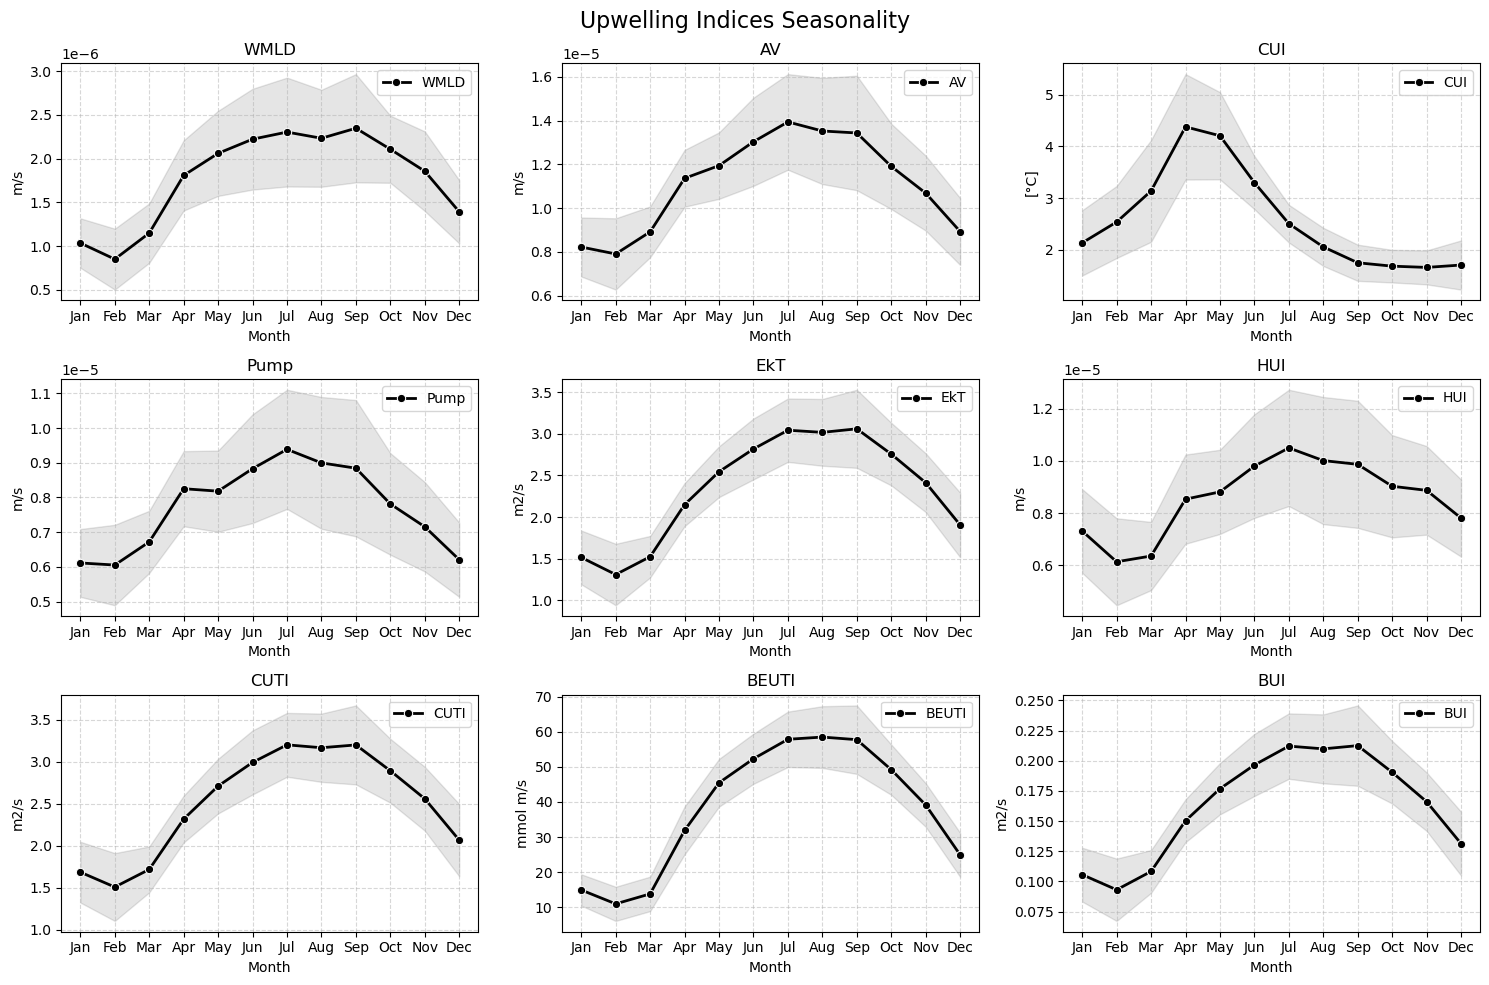

In [93]:
indices = UI_monthly_inter.columns[:9]

# import matplotlib.pyplot as plt
import seaborn as sns

# Define the indices (first 9 columns)
indices = UI_monthly_inter.columns[:9]

# Create a subplot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # 3x3 grid for 9 plots
fig.suptitle('Upwelling Indices Seasonality', fontsize=16)  # Overall title

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the indices and plot each column in a separate subplot
for i, key in enumerate(indices):
    sns.lineplot(
        data=UI_monthly_inter, 
        x='month', 
        y=key, 
        ci='sd', 
        marker='o', 
        color='black', 
        err_kws={'alpha': 0.1},
        linewidth=2, 
        label=key,
        ax=axes[i]  # Plot on the corresponding subplot
    )
    
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].set_title(key)  # Set the title of the subplot to the column name
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel(magnitud[0][i])
    axes[i].set_xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig('Figures/Seasonality_months'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1252060/878125451.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


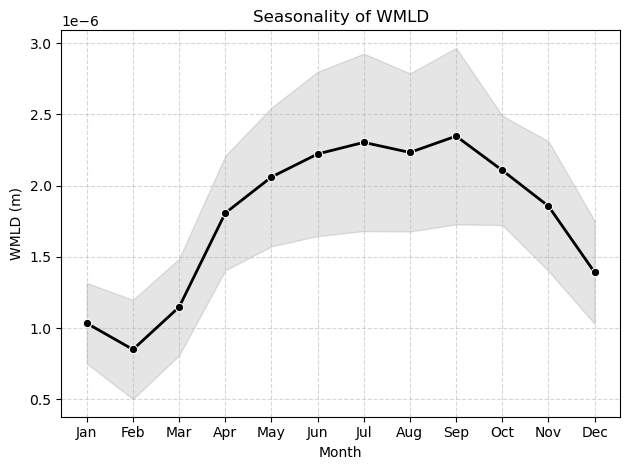

In [128]:
import seaborn as sns

sns.lineplot(
    data=wmld_df, 
    x='month', 
    y='WMLD', 
    ci='sd', 
    marker='o', 
    color='Black', 
        err_kws={'alpha': 0.1},
    linewidth=2
)

plt.grid(True, linestyle='--', alpha=0.5)

# Customize the plot
plt.title('Seasonality of WMLD')
plt.xlabel('Month')
plt.ylabel('WMLD (m)')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()

### Normalization

In [56]:
CUI_norm=normalize(CUI_anomaly.rolling(time=13,center=True).mean())
Pump_norm=normalize(Pump_anomaly.rolling(time=13,center=True).mean())
Ekt_norm=normalize(Ekt_anomaly.rolling(time=13,center=True).mean())
AV_norm=normalize(AV_anomaly.rolling(time=13,center=True).mean())
HUI_norm=normalize(HUI_anomaly.rolling(time=13,center=True).mean())
CUTI_norm=normalize(CUTI_anomaly.rolling(time=13,center=True).mean())
BEUTI_norm=normalize(BEUTI_anomaly.rolling(time=13,center=True).mean())
BUI_norm=normalize(BUI_anomaly.rolling(time=13,center=True).mean())
WMLD_norm=normalize(WMLD_anomaly.rolling(time=13,center=True).mean())

In [57]:
time = pd.date_range(start="1980-01",end="2016-01",freq='M')

UI_dic_inter = {
    # 'time':time,
    'WMLD':WMLD_norm.values,
    'AV':AV_norm.values,
    'CUI':CUI_norm.values,
    # 'Pump':Pump_norm.values,
    'EkT':Ekt_norm.values,
    'HUI':HUI_norm.values,
    'CUTI':CUTI_norm.values,
    'BEUTI':BEUTI_norm.values,
    'BUI':BUI_norm.values
}

normalized_UI = pd.DataFrame(UI_dic_inter)
normalized_UI.index = time
normalized_UI

/tmp/ipykernel_1252060/2551910364.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time = pd.date_range(start="1980-01",end="2016-01",freq='M')


WMLD  AV  CUI  EkT  HUI  CUTI  BEUTI  BUI
1980-01-31   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
1980-02-29   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
1980-03-31   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
1980-04-30   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
1980-05-31   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
...          ...  ..  ...  ...  ...   ...    ...  ...
2015-08-31   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
2015-09-30   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
2015-10-31   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
2015-11-30   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN
2015-12-31   NaN NaN  NaN  NaN  NaN   NaN    NaN  NaN

[432 rows x 8 columns]

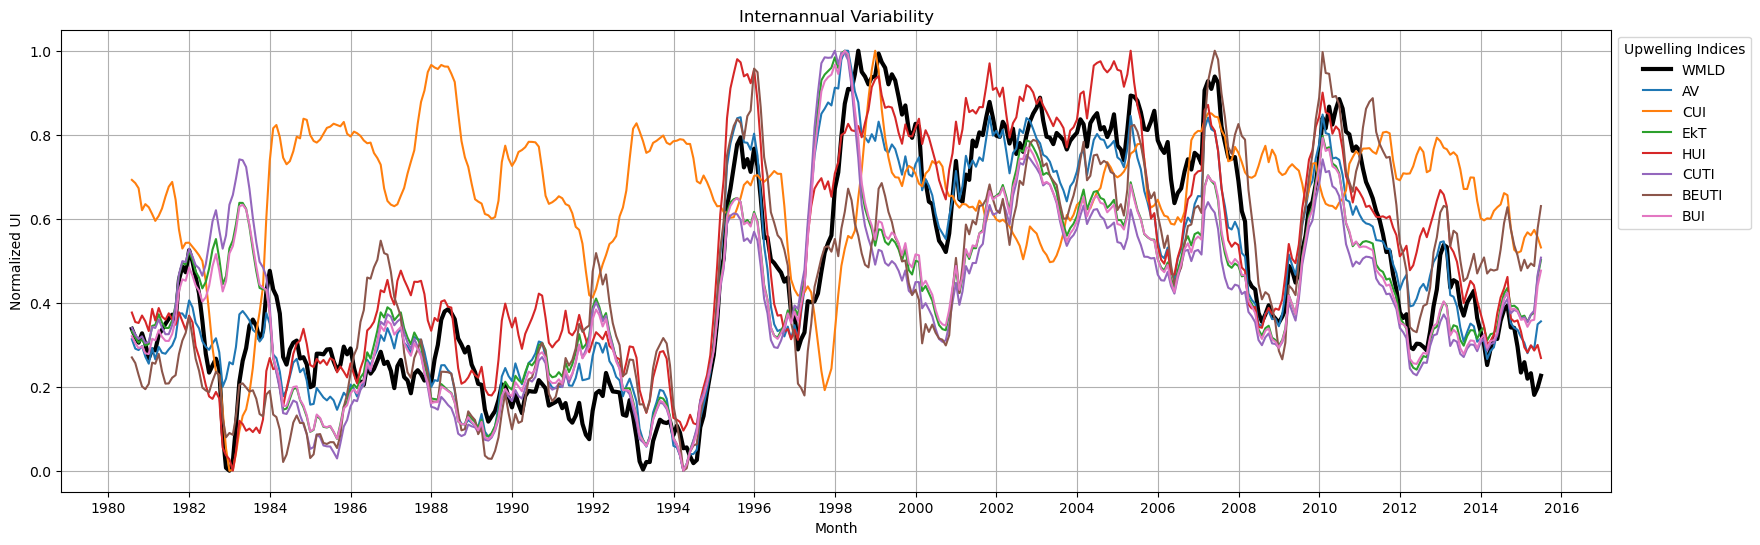

In [58]:
# Assuming 'climatology' is your DataFrame containing the climatology data
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))

# Plot the first column with a solid black line
first_column = normalized_UI.columns[0]
plt.plot(normalized_UI.index, normalized_UI[first_column], label=first_column, color='black', linestyle='-', linewidth=3)

# Iterate over columns and plot each variable
for column in normalized_UI.columns[1:]:
    plt.plot(normalized_UI.index, normalized_UI[column], label=column)

plt.xlabel('Month')
plt.ylabel('Normalized UI')
plt.title('Internannual Variability')
plt.legend(title='Upwelling Indices', bbox_to_anchor=(1, 1))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # Grid lines every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format years as 'YYYY'
plt.grid(visible=True, which='major')

# plt.savefig('Figures/Interannual_variability_npump'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

## ENSO 

### 1996-1999

In [59]:
# BUI_norm.sel(time=slice("1996-01-01","1998-12-31")).plot()

time_ENSO = pd.date_range(start="1996-01",end="2000-01",freq='M')

UI_dic_ENSO = {
    # 'time':time,
    'WMLD':WMLD_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'AV':AV_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'CUI':CUI_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'Pump':Pump_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'EkT':Ekt_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'HUI':HUI_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'CUTI':CUTI_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'BEUTI':BEUTI_norm.sel(time=slice("1996-01-01","1999-12-31")).values,
    'BUI':BUI_norm.sel(time=slice("1996-01-01","1999-12-31")).values
}

normalized_UI_ENSO = pd.DataFrame(UI_dic_ENSO)
normalized_UI_ENSO.index = time_ENSO
normalized_UI_ENSO

/tmp/ipykernel_1252060/3605205137.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_ENSO = pd.date_range(start="1996-01",end="2000-01",freq='M')


WMLD        AV       CUI      Pump       EkT       HUI  \
1996-01-31  0.724841  0.750016  0.703771  0.853685  0.593541  0.880716   
1996-02-29  0.649390  0.653091  0.693800  0.734929  0.527008  0.778499   
1996-03-31  0.553749  0.535105  0.687874  0.593650  0.442621  0.648261   
1996-04-30  0.555683  0.480300  0.695453  0.523013  0.407545  0.565068   
1996-05-31  0.502497  0.391418  0.704011  0.418280  0.340635  0.467135   
1996-06-30  0.494489  0.348843  0.713520  0.360612  0.321547  0.396795   
1996-07-31  0.482709  0.332380  0.706951  0.338103  0.316958  0.369327   
1996-08-31  0.471848  0.336478  0.706850  0.335205  0.333103  0.370643   
1996-09-30  0.450122  0.319839  0.630141  0.296161  0.349457  0.331306   
1996-10-31  0.460225  0.343197  0.529915  0.312965  0.381783  0.337361   
1996-11-30  0.375742  0.314729  0.455185  0.279174  0.358861  0.313077   
1996-12-31  0.375378  0.346581  0.431419  0.313475  0.387474  0.336114   
1997-01-31  0.288866  0.315604  0.417316  0.274034  0.370199  0.311664   
1997-02-28  0.312579  0.374814  0.417130  0.343262  0.414459  0.385238   
1997-03-31  0.329177  0.432467  0.424931  0.413509  0.455218  0.438219   
1997-04-30  0.403686  0.570266  0.438996  0.564910  0.575901  0.561264   
1997-05-31  0.401100  0.661309  0.424584  0.655368  0.670477  0.629835   
1997-06-30  0.403229  0.750073  0.369852  0.726213  0.786699  0.671453   
1997-07-31  0.421951  0.803134  0.304419  0.761672  0.862011  0.685697   
1997-08-31  0.473619  0.849916  0.237564  0.791985  0.929437  0.696539   
1997-09-30  0.519530  0.862043  0.191898  0.797938  0.943281  0.670286   
1997-10-31  0.542316  0.876840  0.217420  0.817446  0.951645  0.689072   
1997-11-30  0.560135  0.869688  0.243346  0.800975  0.959454  0.652355   
1997-12-31  0.671362  0.912069  0.330156  0.858846  0.984340  0.707968   
1998-01-31  0.710442  0.909898  0.419549  0.872810  0.958639  0.734950   
1998-02-28  0.795759  0.978582  0.487822  0.963192  0.994062  0.799248   
1998-03-31  0.873897  1.000000  0.528799  0.993721  1.000000  0.804678   
1998-04-30  0.909001  0.999850  0.558983  1.000000  0.988999  0.825882   
1998-05-31  0.907698  0.954454  0.553334  0.963008  0.926877  0.810708   
1998-06-30  0.943886  0.903357  0.571492  0.930530  0.845225  0.808563   
1998-07-31  1.000000  0.876984  0.649997  0.934674  0.773645  0.820508   
1998-08-31  0.949790  0.799319  0.716110  0.877891  0.668011  0.793805   
1998-09-30  0.938493  0.793982  0.803244  0.900429  0.624684  0.828480   
1998-10-31  0.919803  0.781781  0.885337  0.901165  0.597462  0.859161   
1998-11-30  0.936274  0.801335  0.953815  0.947289  0.574479  0.913551   
1998-12-31  0.939151  0.785346  1.000000  0.943658  0.535727  0.932230   
1999-01-31  0.993185  0.831135  0.954013  0.987765  0.574759  0.939386   
1999-02-28  0.973056  0.802035  0.860534  0.939100  0.573218  0.893747   
1999-03-31  0.959358  0.763832  0.792937  0.893189  0.545193  0.864082   
1999-04-30  0.919972  0.757283  0.745630  0.885709  0.537955  0.867009   
1999-05-31  0.943828  0.776940  0.710115  0.906124  0.551682  0.864705   
1999-06-30  0.929184  0.765968  0.698845  0.893269  0.543466  0.841079   
1999-07-31  0.890090  0.737499  0.697803  0.857346  0.526746  0.804619   
1999-08-31  0.847942  0.704775  0.677676  0.821993  0.499915  0.778465   
1999-09-30  0.869789  0.748657  0.711197  0.877149  0.527660  0.824643   
1999-10-31  0.810517  0.705782  0.725789  0.837948  0.477659  0.796816   
1999-11-30  0.792596  0.700527  0.720999  0.836027  0.467211  0.795883   
1999-12-31  0.825938  0.730116  0.706960  0.863457  0.499793  0.817203   

                CUTI     BEUTI       BUI  
1996-01-31  0.547604  0.948938  0.589691  
1996-02-29  0.487300  0.865134  0.521117  
1996-03-31  0.409253  0.746225  0.438438  
1996-04-30  0.375146  0.702695  0.405804  
1996-05-31  0.311134  0.615439  0.341094  
1996-06-30  0.294143  0.590411  0.320854  
1996-07-31  0.292315  0.560688  0.313862  
1996-08-31  0.309876  0.550955  0.327201  
19

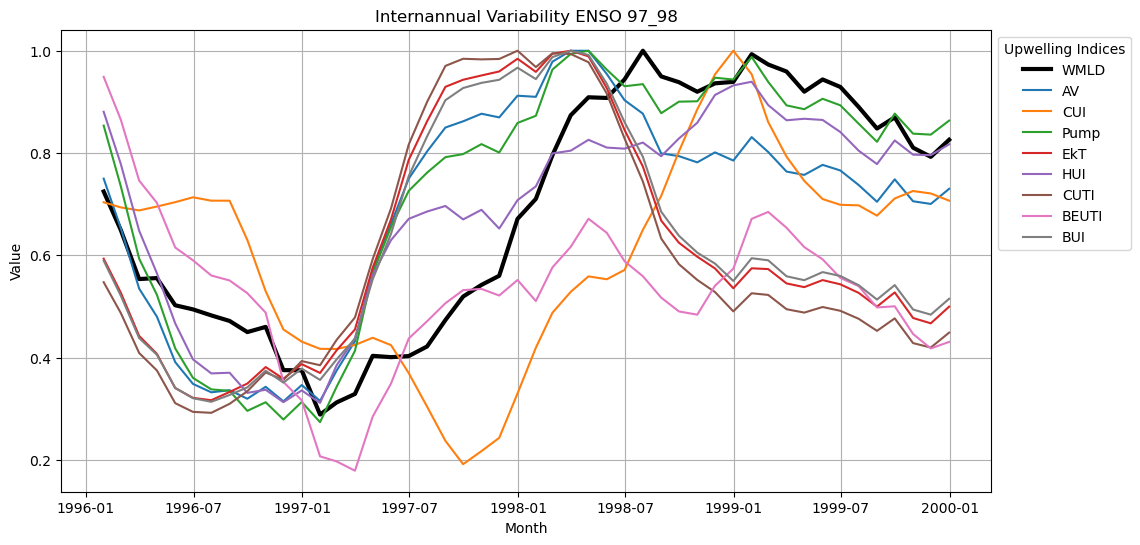

In [60]:
plt.figure(figsize=(12, 6))

# Plot the first column with a solid black line
first_column = normalized_UI_ENSO.columns[0]
plt.plot(normalized_UI_ENSO.index, normalized_UI_ENSO[first_column], label=first_column, color='black', linestyle='-', linewidth=3)

# Iterate over columns and plot each variable
for column in normalized_UI_ENSO.columns[1:]:
    plt.plot(normalized_UI_ENSO.index, normalized_UI_ENSO[column], label=column)

plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Internannual Variability ENSO 97_98')
plt.legend(title='Upwelling Indices', bbox_to_anchor=(1, 1))
plt.grid(visible=True, which='major')


# plt.savefig('IA_ENSO_97_98'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

### 1981-1984

In [61]:
# BUI_norm.sel(time=slice("1996-01-01","1998-12-31")).plot()

time_ENSO = pd.date_range(start="1981-01",end="1985-01",freq='M')

UI_dic_ENSO = {
    # 'time':time,
    'WMLD':WMLD_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'AV':AV_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'CUI':CUI_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'Pump':Pump_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'EkT':Ekt_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'HUI':HUI_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'CUTI':CUTI_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'BEUTI':BEUTI_norm.sel(time=slice("1981-01-01","1984-12-31")).values,
    'BUI':BUI_norm.sel(time=slice("1981-01-01","1984-12-31")).values
}

normalized_UI_ENSO = pd.DataFrame(UI_dic_ENSO)
normalized_UI_ENSO.index = time_ENSO
normalized_UI_ENSO

/tmp/ipykernel_1252060/1670786787.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_ENSO = pd.date_range(start="1981-01",end="1985-01",freq='M')


WMLD        AV       CUI      Pump       EkT       HUI  \
1981-01-31  0.288922  0.292181  0.610972  0.266688  0.344821  0.385482   
1981-02-28  0.286585  0.265212  0.594869  0.221238  0.347108  0.357552   
1981-03-31  0.323366  0.294750  0.606779  0.251540  0.372511  0.387344   
1981-04-30  0.335438  0.280801  0.624448  0.238179  0.352742  0.367050   
1981-05-31  0.349817  0.278518  0.652634  0.241710  0.339829  0.359533   
1981-06-30  0.361975  0.288916  0.676200  0.259708  0.339989  0.374818   
1981-07-31  0.371551  0.298187  0.687620  0.263188  0.358114  0.360774   
1981-08-31  0.357537  0.317748  0.645223  0.270534  0.394340  0.347697   
1981-09-30  0.454230  0.374490  0.574764  0.315826  0.465261  0.377223   
1981-10-31  0.486217  0.374471  0.528978  0.295541  0.495184  0.355451   
1981-11-30  0.472498  0.363328  0.542519  0.280208  0.490721  0.335030   
1981-12-31  0.525145  0.405560  0.542998  0.330783  0.523305  0.369278   
1982-01-31  0.498077  0.388876  0.532966  0.319962  0.501112  0.353528   
1982-02-28  0.462447  0.352396  0.524001  0.279209  0.474630  0.296480   
1982-03-31  0.422052  0.339008  0.512883  0.268784  0.459565  0.270828   
1982-04-30  0.357074  0.308161  0.499143  0.238348  0.434166  0.239843   
1982-05-31  0.278557  0.295198  0.451721  0.209913  0.449434  0.203820   
1982-06-30  0.233613  0.287821  0.376952  0.177488  0.481341  0.176917   
1982-07-31  0.250580  0.302957  0.292184  0.171135  0.526548  0.171089   
1982-08-31  0.266763  0.315393  0.235240  0.173797  0.551647  0.187591   
1982-09-30  0.241701  0.281974  0.227907  0.146945  0.505269  0.172275   
1982-10-31  0.091163  0.200147  0.143181  0.047849  0.444083  0.054835   
1982-11-30  0.006918  0.219171  0.053060  0.063643  0.463328  0.036642   
1982-12-31  0.000000  0.258355  0.000000  0.084466  0.529458  0.027262   
1983-01-31  0.022502  0.253374  0.002251  0.060431  0.548433  0.000000   
1983-02-28  0.106243  0.294581  0.041076  0.101899  0.586502  0.044431   
1983-03-31  0.211809  0.372305  0.094670  0.193692  0.637820  0.118838   
1983-04-30  0.261738  0.380259  0.130560  0.202640  0.637587  0.111025   
1983-05-31  0.291814  0.369852  0.146100  0.189933  0.623659  0.095156   
1983-06-30  0.344993  0.358187  0.185285  0.195907  0.581238  0.100337   
1983-07-31  0.359867  0.335380  0.244862  0.192595  0.525713  0.092015   
1983-08-31  0.344699  0.328327  0.330170  0.215406  0.475343  0.102734   
1983-09-30  0.313074  0.307601  0.377548  0.209676  0.435223  0.089634   
1983-10-31  0.331845  0.318623  0.438776  0.231806  0.431964  0.122230   
1983-11-30  0.424829  0.375565  0.602674  0.329963  0.430737  0.237441   
1983-12-31  0.475974  0.349968  0.737892  0.326958  0.374900  0.268266   
1984-01-31  0.431669  0.276696  0.815467  0.273085  0.268327  0.241811   
1984-02-29  0.415613  0.268175  0.823116  0.278608  0.236165  0.244853   
1984-03-31  0.374347  0.235934  0.794457  0.245903  0.201774  0.196252   
1984-04-30  0.270989  0.177117  0.745444  0.183919  0.145275  0.153343   
1984-05-31  0.252644  0.192099  0.729590  0.208272  0.148020  0.194170   
1984-06-30  0.288735  0.224044  0.737075  0.246406  0.171088  0.230319   
1984-07-31  0.304829  0.257342  0.760487  0.285901  0.194665  0.278192   
1984-08-31  0.309919  0.266339  0.795496  0.300308  0.196835  0.302909   
1984-09-30  0.267183  0.234563  0.791381  0.266731  0.168246  0.309721   
1984-10-31  0.270280  0.243664  0.838097  0.291810  0.151320  0.337847   
1984-11-30  0.253067  0.214118  0.835286  0.258408  0.128443  0.301763   
1984-12-31  0.198767  0.157319  0.799260  0.189729  0.092549  0.251665   

                CUTI     BEUTI       BUI  
1981-01-31  0.342119  0.257390  0.314203  
1981-02-28  0.339942  0.254724  0.310373  
1981-03-31  0.360181  0.278023  0.334431  
1981-04-30  0.340846  0.236608  0.318840  
1981-05-31  0.324973  0.207389  0.309186  
1981-06-30  0.325124  0.207854  0.308969  
1981-07-31  0.346706  0.221450  0.325613  
1981-08-31  0.392701  0.227506  0.359289  
19

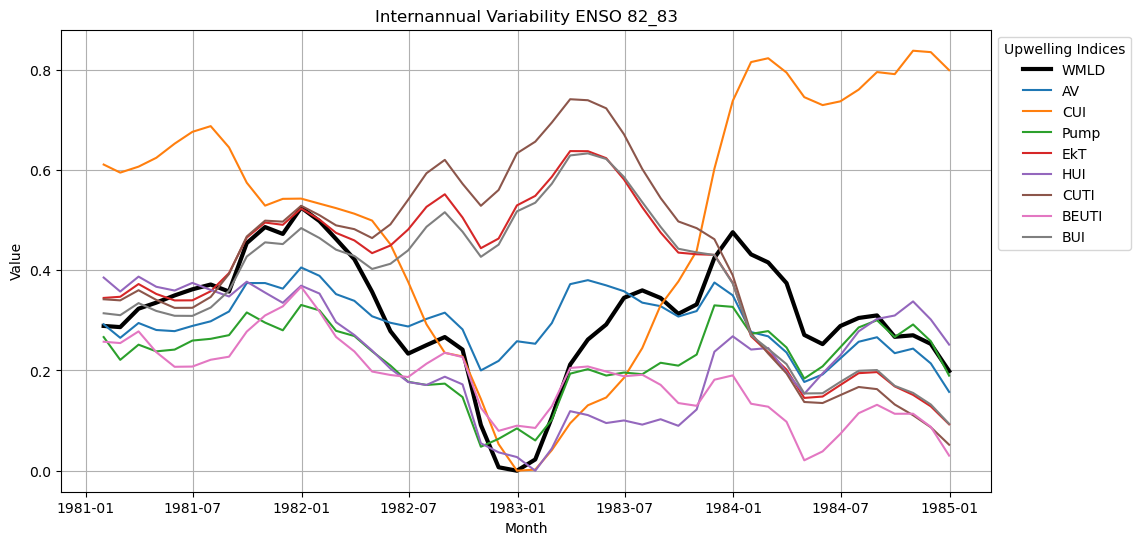

In [62]:
plt.figure(figsize=(12, 6))

# Plot the first column with a solid black line
first_column = normalized_UI_ENSO.columns[0]
plt.plot(normalized_UI_ENSO.index, normalized_UI_ENSO[first_column], label=first_column, color='black', linestyle='-', linewidth=3)

# Iterate over columns and plot each variable
for column in normalized_UI_ENSO.columns[1:]:
    plt.plot(normalized_UI_ENSO.index, normalized_UI_ENSO[column], label=column)

plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Internannual Variability ENSO 82_83')
plt.legend(title='Upwelling Indices', bbox_to_anchor=(1, 1))
plt.grid(True)

# plt.savefig('Figures/IA_ENSO_8283'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

## Correlations

### Seasonal

In [63]:
corr_matrix = round(normalized_mmonth.corr(method='pearson'),2)
print(corr_matrix)

       WMLD    AV   CUI   EkT   HUI  CUTI  BEUTI   BUI
WMLD   1.00  0.98  0.01  0.99  0.96  0.99   0.98  0.99
AV     0.98  1.00  0.07  0.97  0.95  0.98   0.97  0.98
CUI    0.01  0.07  1.00 -0.11 -0.09 -0.10  -0.10 -0.10
EkT    0.99  0.97 -0.11  1.00  0.97  1.00   1.00  1.00
HUI    0.96  0.95 -0.09  0.97  1.00  0.97   0.97  0.97
CUTI   0.99  0.98 -0.10  1.00  0.97  1.00   1.00  1.00
BEUTI  0.98  0.97 -0.10  1.00  0.97  1.00   1.00  1.00
BUI    0.99  0.98 -0.10  1.00  0.97  1.00   1.00  1.00


<Axes: >

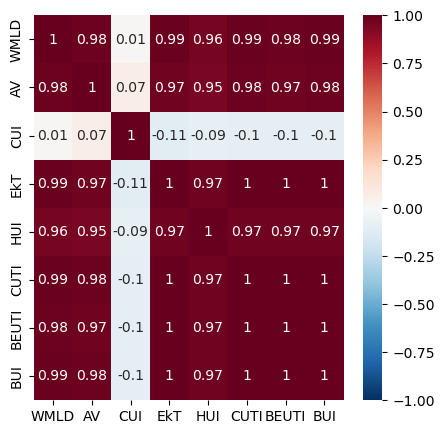

In [64]:
import seaborn as sn

fig=plt.figure(figsize=(5,5))
sn.heatmap(corr_matrix, annot=True,cmap="RdBu_r", vmin=-1, vmax=1)

### Interannual

In [65]:
# normalized_UI
corr_matrix_inter = round(normalized_UI.corr(method='pearson'),2)
print(corr_matrix_inter)

       WMLD    AV   CUI   EkT   HUI  CUTI  BEUTI   BUI
WMLD   1.00  0.93  0.08  0.79  0.90  0.71   0.79  0.81
AV     0.93  1.00 -0.11  0.91  0.94  0.85   0.81  0.92
CUI    0.08 -0.11  1.00 -0.42  0.12 -0.53   0.04 -0.40
EkT    0.79  0.91 -0.42  1.00  0.75  0.99   0.74  1.00
HUI    0.90  0.94  0.12  0.75  1.00  0.67   0.80  0.77
CUTI   0.71  0.85 -0.53  0.99  0.67  1.00   0.67  0.99
BEUTI  0.79  0.81  0.04  0.74  0.80  0.67   1.00  0.75
BUI    0.81  0.92 -0.40  1.00  0.77  0.99   0.75  1.00


### Year

In [94]:
CUI_yr=CUI_cut.mean(dim='lat', skipna=True).groupby('time.year').mean(dim='time',skipna=True)
Pump_yr=EK_ds['EKp_lat'].mean(dim='lat', skipna=True).groupby('time.year').mean(dim='time',skipna=True)
Ekt_yr=Ekt_anomaly.groupby('time.year').mean(dim='time',skipna=True)
AV_yr=AV_ds['AV'].mean(dim='lat',skipna=True).groupby('time.year').mean(dim='time',skipna=True)
HUI_yr=HUI_ds['HUI'].mean(dim='lat',skipna=True).groupby('time.year').mean(dim='time',skipna=True)
CUTI_yr=CUTI_ds['CUTI'].mean(dim='lat', skipna=True).groupby('time.year').mean(dim='time',skipna=True)
BEUTI_yr=BEUTI_ds['BEUTI'].mean(dim='lat', skipna=True).groupby('time.year').mean(dim='time',skipna=True)
BUI_yr=BUI_ds['BUI'].mean(dim='lat', skipna=True).groupby('time.year').mean(dim='time',skipna=True)
WMLD_yr=WMLD_ds['WMLD'].mean(dim='lat', skipna=True).groupby('time.year').mean(dim='time',skipna=True)

In [95]:
time_yr = pd.date_range(start="1980-01",end="2016-01",freq='Y')

UI_dic_yr = {
    # 'time':time,
    'WMLD':WMLD_yr.values,
    'AV':AV_yr.values,
    'CUI':CUI_yr.values,
    'Pump':Pump_yr.values,
    'EkT':Ekt_yr.values,
    'HUI':HUI_yr.values,
    'CUTI':CUTI_yr.values,
    'BEUTI':BEUTI_yr.values,
    'BUI':BUI_yr.values
}

UI_year = pd.DataFrame(UI_dic_yr)
UI_year.index = time_yr
UI_year

/tmp/ipykernel_1503244/2150093552.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  time_yr = pd.date_range(start="1980-01",end="2016-01",freq='Y')


WMLD        AV       CUI      Pump       EkT       HUI  \
1980-12-31  0.000002  0.000010  2.643586  0.000007 -0.100479  0.000008   
1981-12-31  0.000002  0.000010  2.635332  0.000007 -0.082879  0.000008   
1982-12-31  0.000002  0.000010  1.936943  0.000007  0.080772  0.000007   
1983-12-31  0.000002  0.000011  1.685362  0.000007  0.151755  0.000007   
1984-12-31  0.000002  0.000010  2.748799  0.000007 -0.235791  0.000008   
1985-12-31  0.000002  0.000010  2.896991  0.000007 -0.350863  0.000007   
1986-12-31  0.000002  0.000010  2.835100  0.000007 -0.146467  0.000008   
1987-12-31  0.000002  0.000010  2.728780  0.000007 -0.098325  0.000008   
1988-12-31  0.000002  0.000010  3.131099  0.000007 -0.257911  0.000008   
1989-12-31  0.000001  0.000009  2.428279  0.000007 -0.337620  0.000007   
1990-12-31  0.000001  0.000010  2.846105  0.000007 -0.164056  0.000008   
1991-12-31  0.000001  0.000010  2.479169  0.000007 -0.156879  0.000008   
1992-12-31  0.000001  0.000010  2.375751  0.000007 -0.145603  0.000008   
1993-12-31  0.000001  0.000010  2.834863  0.000007 -0.284976  0.000007   
1994-12-31  0.000001  0.000009  2.703430  0.000006 -0.387657  0.000007   
1995-12-31  0.000002  0.000013  2.501343  0.000009  0.253833  0.000011   
1996-12-31  0.000002  0.000011  2.694037  0.000007 -0.106407  0.000008   
1997-12-31  0.000002  0.000013  1.971212  0.000009  0.435190  0.000010   
1998-12-31  0.000002  0.000013  2.508430  0.000009  0.387807  0.000010   
1999-12-31  0.000002  0.000013  2.659172  0.000009  0.149258  0.000010   
2000-12-31  0.000002  0.000012  2.733175  0.000009 -0.063562  0.000010   
2001-12-31  0.000002  0.000013  2.528899  0.000009  0.133536  0.000010   
2002-12-31  0.000002  0.000013  2.366173  0.000009  0.323934  0.000010   
2003-12-31  0.000002  0.000012  2.302357  0.000008  0.200887  0.000010   
2004-12-31  0.000002  0.000013  2.613738  0.000009  0.232351  0.000010   
2005-12-31  0.000002  0.000013  2.839296  0.000009  0.217057  0.000010   
2006-12-31  0.000002  0.000011  2.452359  0.000008  0.073442  0.000009   
2007-12-31  0.000002  0.000012  2.951266  0.000009  0.202872  0.000010   
2008-12-31  0.000002  0.000011  2.730446  0.000007 -0.083695  0.000008   
2009-12-31  0.000002  0.000012  2.677444  0.000008  0.038685  0.000009   
2010-12-31  0.000002  0.000012  2.540073  0.000009  0.275127  0.000010   
2011-12-31  0.000002  0.000012  2.812637  0.000008  0.074240  0.000009   
2012-12-31  0.000002  0.000011  2.770805  0.000008 -0.161196  0.000009   
2013-12-31  0.000002  0.000011  2.682291  0.000007 -0.122510  0.000008   
2014-12-31  0.000002  0.000011  2.568148  0.000008 -0.005171  0.000008   
2015-12-31  0.000001  0.000011  2.295536  0.000007  0.061302  0.000007   

                CUTI      BEUTI       BUI  
1980-12-31  2.423978  35.325856  0.155394  
1981-12-31  2.414387  34.666898  0.155174  
1982-12-31  2.681688  34.452653  0.165877  
1983-12-31  2.777093  34.662652  0.174824  
1984-12-31  2.240616  33.123197  0.147085  
1985-12-31  2.091257  32.407252  0.138673  
1986-12-31  2.333126  38.807669  0.151082  
1987-12-31  2.404406  35.166968  0.154346  
1988-12-31  2.202873  34.625081  0.145090  
1989-12-31  2.148221  32.117743  0.138917  
1990-12-31  2.300800  35.200353  0.150277  
1991-12-31  2.325928  35.716729  0.150584  
1992-12-31  2.361444  36.443969  0.152715  
1993-12-31  2.205297  35.599129  0.142658  
1994-12-31  2.107156  31.898087  0.135460  
1995-12-31  2.751512  43.983682  0.181368  
1996-12-31  2.375806  40.075282  0.155597  
1997-12-31  3.028771  38.326845  0.191675  
1998-12-31  2.910867  39.652127  0.192160  
1999-12-31  2.624125  40.003520  0.175027  
2000-12-31  2.416413  36.294113  0.159609  
2001-12-31  2.625517  40.513592  0.173079  
2002-12-31  2.836847  40.855160  0.184880  
2003-12-31  2.711595  40.621565  0.176267  
2004-12-31  2.724493  42.175560  0.178998  
2005-12-31  2.683523  43.499497  0.178432  
2006-12-31  2.583680  38.325395  0.167634  
2007-12-31  2.665849  45.625929  0.178509  
2

In [96]:
corr_matrix_yr = round(UI_year.corr(method='pearson'),2)
print(corr_matrix_yr)

       WMLD    AV   CUI  Pump   EkT   HUI  CUTI  BEUTI   BUI
WMLD   1.00  0.91  0.01  0.92  0.79  0.89  0.71   0.78  0.82
AV     0.91  1.00 -0.16  0.98  0.91  0.94  0.86   0.80  0.93
CUI    0.01 -0.16  1.00 -0.01 -0.46  0.07 -0.56   0.06 -0.43
Pump   0.92  0.98 -0.01  1.00  0.82  0.98  0.75   0.79  0.85
EkT    0.79  0.91 -0.46  0.82  1.00  0.76  0.99   0.74  1.00
HUI    0.89  0.94  0.07  0.98  0.76  1.00  0.68   0.78  0.78
CUTI   0.71  0.86 -0.56  0.75  0.99  0.68  1.00   0.66  0.98
BEUTI  0.78  0.80  0.06  0.79  0.74  0.78  0.66   1.00  0.75
BUI    0.82  0.93 -0.43  0.85  1.00  0.78  0.98   0.75  1.00


## Stratification

In [97]:
MLD = loadmat("../../NHCS/Processed/WMLD_MLD.mat")
print(MLD.keys())

dict_keys(['__header__', '__version__', '__globals__', 'MLD', 'WMLD'])


In [98]:
# ¨WMLD_MLD
SST = loadmat("../../NHCS/Processed/SST_SSH.mat")
print(SST.keys())

dict_keys(['__header__', '__version__', '__globals__', 'SSH', 'SST'])


In [99]:
# EKMAN_components

Curl = loadmat("../../NHCS/Processed/EKMAN_components.mat")
print(Curl.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Curl', 'Divergence', 'Crosshore_wind', 'VTauy', 'EK_pump', 'UEK', 'VEK', 'LTM_ekpump'])


In [100]:
## mask
print(ds.mask_rho.shape)
mask_rho = ds.mask_rho.values 
mask_nan = np.where(mask_rho, 1, np.nan)
expanded_mask = np.tile(mask_nan[np.newaxis, :, :], (432, 1, 1))
print(expanded_mask.shape)

(542, 602)
(432, 542, 602)


In [101]:
Strat_ds = xr.Dataset(
    data_vars={
        'MLD': (("time", "lat","lon"), MLD['MLD'].transpose(2, 1, 0)*expanded_mask),
        'Curl':(("time", "lat","lon"), Curl['Curl'].transpose(2, 1, 0)*-1),
        'SST':(("time", "lat","lon"), SST['SST'].transpose(2, 1, 0)*expanded_mask),
        'SSH':(("time", "lat","lon"), SST['SSH'].transpose(2, 1, 0)*expanded_mask),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

Strat_ds

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    MLD      (time, lat, lon) float64 1GB 0.9402 0.9402 1.335 ... nan nan nan
    Curl     (time, lat, lon) float64 1GB 2.585e-08 3.833e-08 ... nan nan
    SST      (time, lat, lon) float64 1GB 20.19 20.18 20.24 ... nan nan nan
    SSH      (time, lat, lon) float64 1GB 0.212 0.212 0.2117 ... nan nan nan

In [102]:
Strat_ds_cut = Strat_ds * inshore_mask
Strat_ts = Strat_ds_cut.sel(lat=slice(-16,-5),lon=slice(-84,-73))
Strat_ts

<xarray.Dataset> Size: 245MB
Dimensions:  (lon: 132, lat: 134, time: 432)
Coordinates:
  * lon      (lon) float64 1kB -83.95 -83.87 -83.78 ... -73.2 -73.12 -73.03
  * lat      (lat) float64 1kB -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    MLD      (time, lat, lon) float64 61MB nan nan nan nan ... nan nan nan nan
    Curl     (time, lat, lon) float64 61MB nan nan nan nan ... nan nan nan nan
    SST      (time, lat, lon) float64 61MB nan nan nan nan ... nan nan nan nan
    SSH      (time, lat, lon) float64 61MB nan nan nan nan ... nan nan nan nan

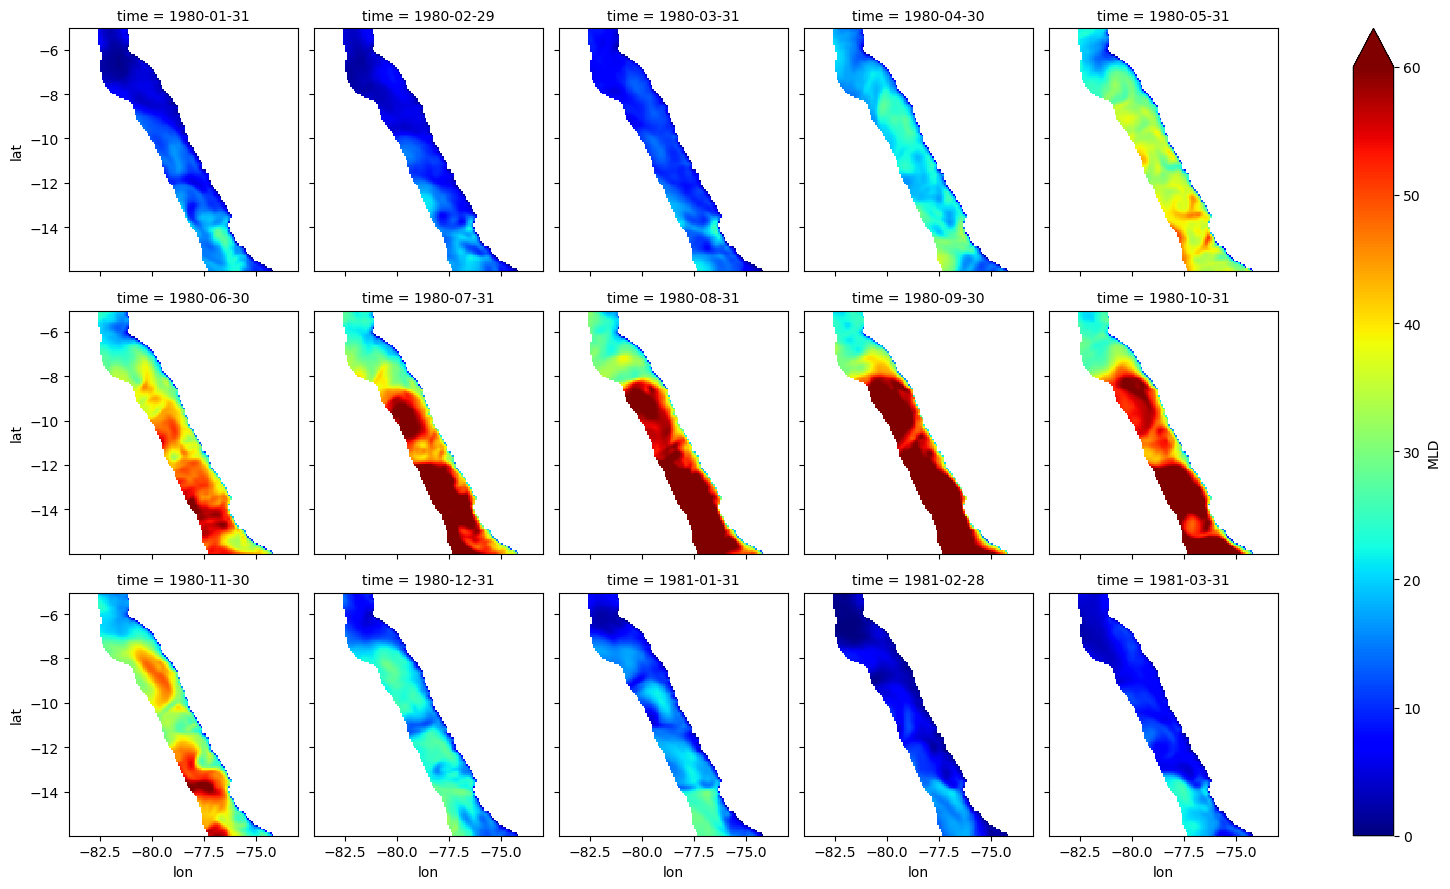

In [103]:
Strat_ts.MLD.isel(time=slice(0,15)).plot(x="lon", y="lat", col="time", col_wrap=5, vmin=0,vmax=60,cmap='jet')

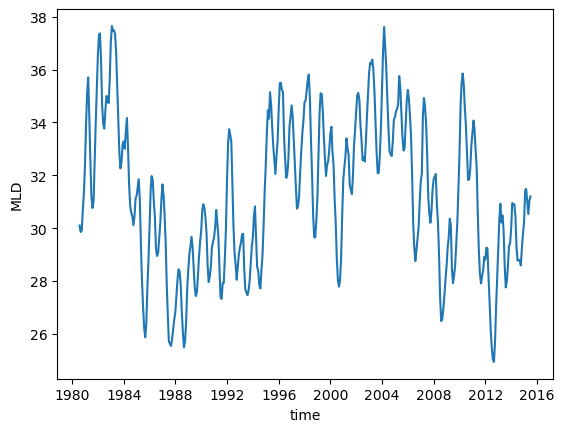

In [104]:
Strat_ts.mean(dim=('lat','lon'),skipna=True).MLD.rolling(time=13,center=True).mean().plot()

In [105]:
strat_mmean = Strat_ts.mean(dim=('lat','lon'),skipna=True).groupby('time.month').mean(dim='time')
strat_anomaly = Strat_ts.mean(dim=('lat','lon'),skipna=True).groupby('time.month') - strat_mmean
strat_anomaly

<xarray.Dataset> Size: 21kB
Dimensions:  (time: 432)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
    month    (time) int64 3kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    MLD      (time) float64 3kB -1.559 -0.7551 -2.023 ... 0.5015 9.337 12.98
    Curl     (time) float64 3kB -7.017e-09 -1.062e-08 ... -2.013e-09 -4.638e-09
    SST      (time) float64 3kB -0.5635 -0.6338 -0.09621 ... 1.342 1.548 1.367
    SSH      (time) float64 3kB 0.001693 -0.002872 0.01511 ... 0.05473 0.06197

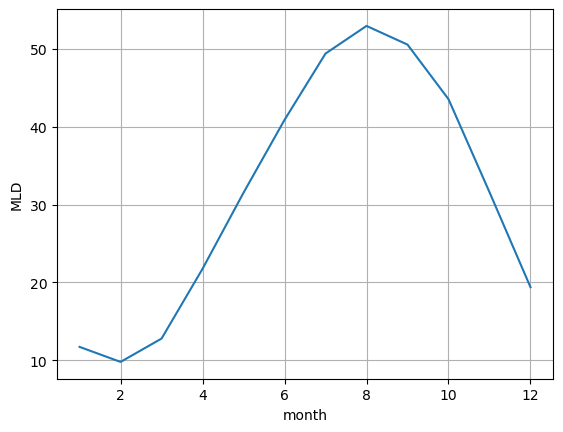

In [106]:
strat_mmean.MLD.plot()
plt.grid(True)

In [107]:
##Normalize
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [108]:
strat_norm = normalize(strat_anomaly.rolling(time=13,center=True).mean())


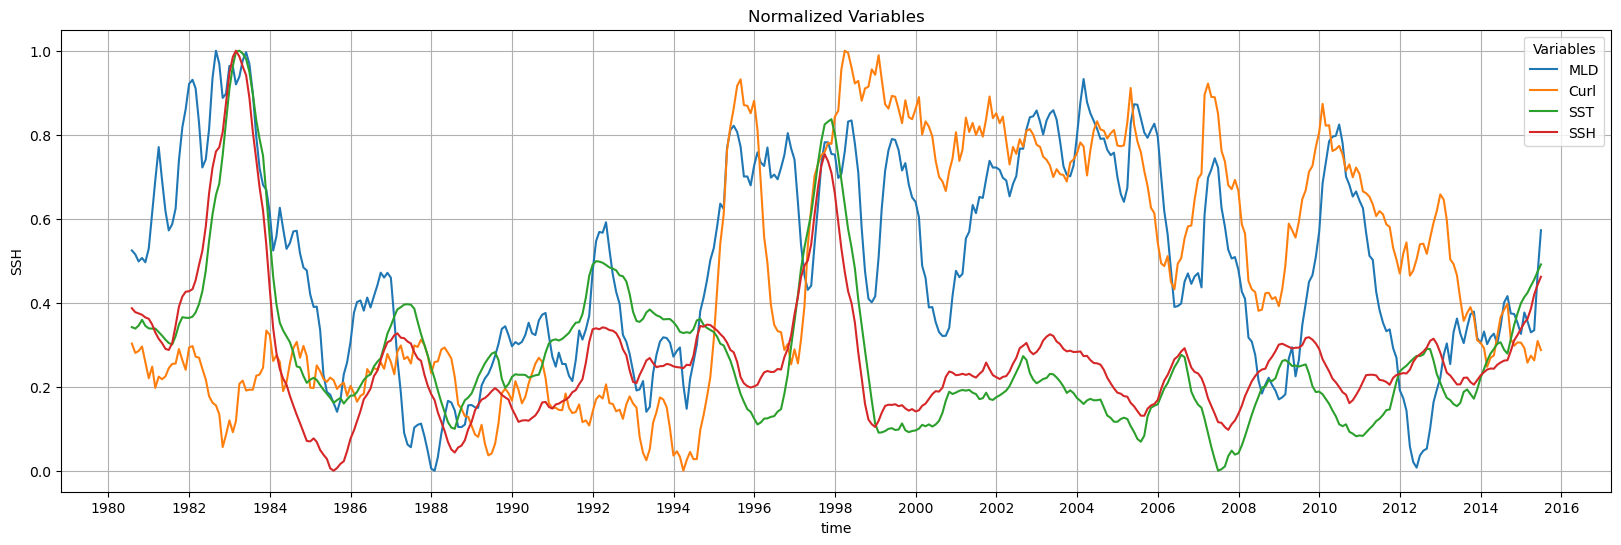

In [109]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6))

strat_norm.MLD.plot(ax=ax,label='MLD')
strat_norm.Curl.plot(ax=ax,label='Curl')
strat_norm.SST.plot(ax=ax,label='SST')
strat_norm.SSH.plot(ax=ax,label='SSH')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # Grid lines every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format years as 'YYYY'
plt.grid(visible=True, which='major')
plt.title('Normalized Variables')
ax.legend(title='Variables', bbox_to_anchor=(1, 1))

# plt.savefig('Figures/ENSO_components'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')


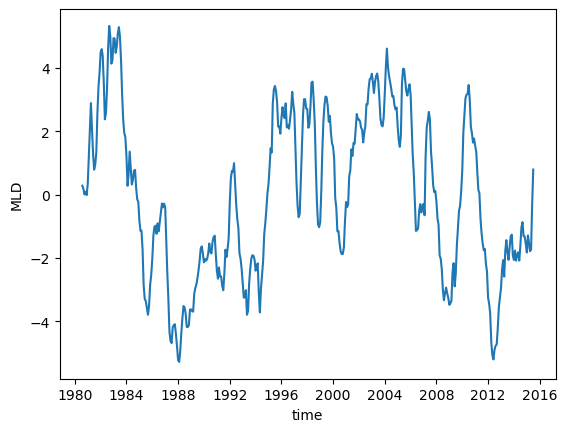

In [110]:
strat_anomaly.MLD.rolling(time=13,center=True).mean().plot()
# strat_anomaly.Curl.rolling(time=13,center=True).mean().plot()
# strat_anomaly.SST.rolling(time=13,center=True).mean().plot()
# strat_anomaly.SSH.rolling(time=13,center=True).mean().plot()

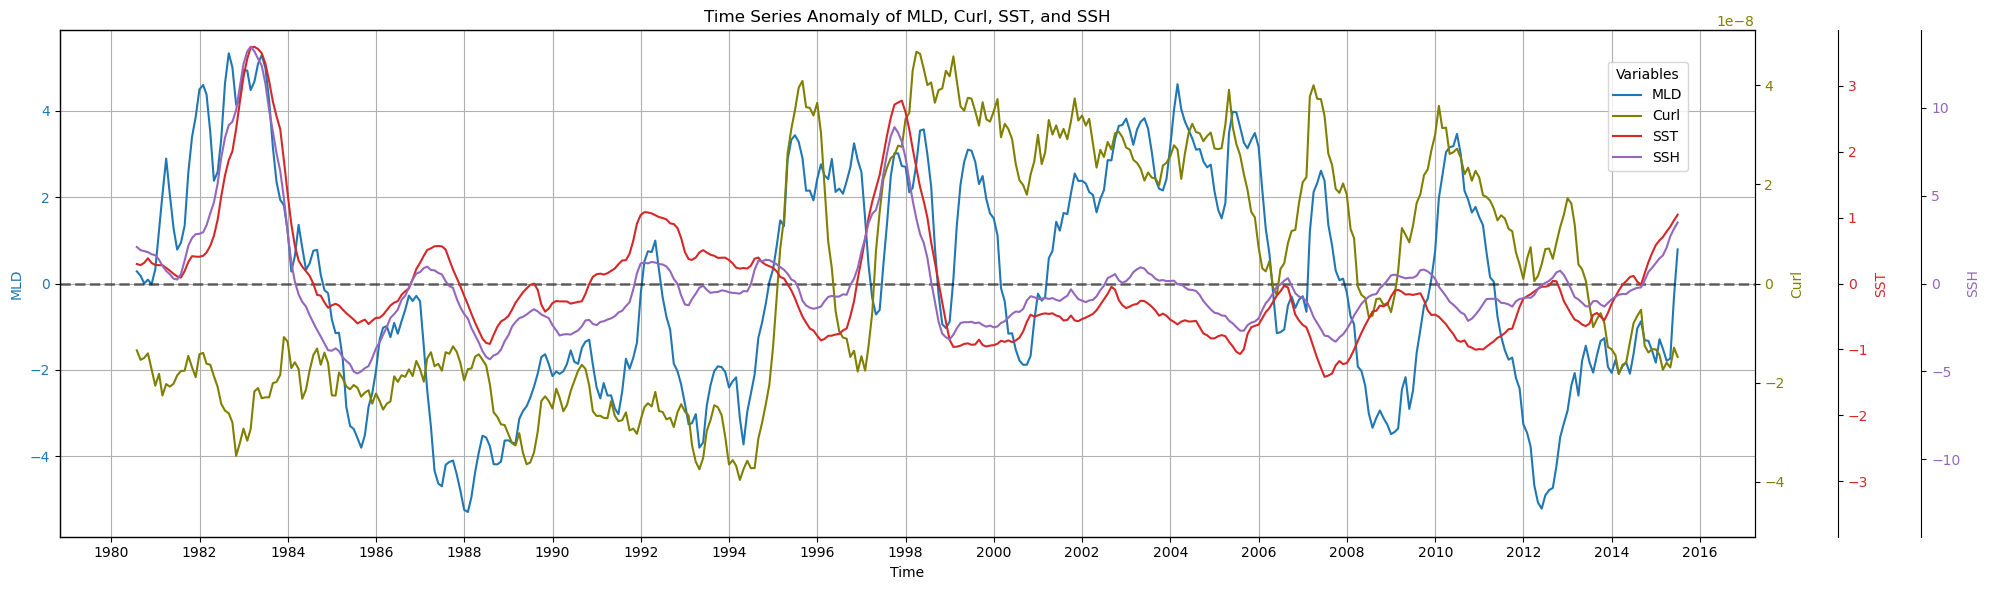

In [111]:
# Assuming strat_anomaly is your dataset
# Compute rolling means for each variable
mld_rolling = strat_anomaly.MLD.rolling(time=13, center=True).mean()
curl_rolling = strat_anomaly.Curl.rolling(time=13, center=True).mean()
sst_rolling = strat_anomaly.SST.rolling(time=13, center=True).mean()
ssh_rolling = strat_anomaly.SSH.rolling(time=13, center=True).mean()*100 #in cm

# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(20, 6))
# Plot the first variable (MLD) on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('MLD', color=color)
ax1.plot(mld_rolling.time, mld_rolling, color=color, label='MLD')
ax1.tick_params(axis='y', labelcolor=color)

ax1 = plt.gca()
ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))  # Grid lines every 2 years
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format years as 'YYYY'
ax1.grid(visible=True, which='major')
# Create a second y-axis and plot the second variable (Curl)
ax2 = ax1.twinx()
color = 'olive'
ax2.set_ylabel('Curl', color=color)
ax2.plot(curl_rolling.time, curl_rolling, color=color, label='Curl')
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis and plot the third variable (SST)
ax3 = ax1.twinx()
color = 'tab:red'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.set_ylabel('SST', color=color)
ax3.plot(sst_rolling.time, sst_rolling, color=color, label='SST')
ax3.tick_params(axis='y', labelcolor=color)

# Create a fourth y-axis and plot the fourth variable (SSH)
ax4 = ax1.twinx()
color = 'tab:purple'
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.set_ylabel('SSH', color=color)
ax4.plot(ssh_rolling.time, ssh_rolling, color=color, label='SSH')
ax4.tick_params(axis='y', labelcolor=color)

# Align the y-axes so that 0 coincides
def align_y_axes_at_zero(axes):
    """Align the y-axes of multiple axes so that 0 coincides."""
    for ax in axes:
        y_min, y_max = ax.get_ylim()
        # Calculate the maximum absolute value to ensure 0 is centered
        max_abs = max(abs(y_min), abs(y_max))
        ax.set_ylim(-max_abs, max_abs)

align_y_axes_at_zero([ax1, ax2, ax3, ax4])

# Plot a horizontal line at 0
ax1.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)

# Add a legend
fig.legend(title='Variables', bbox_to_anchor=(0.85, 0.9))

# Adjust layout
plt.title('Time Series Anomaly of MLD, Curl, SST, and SSH')
fig.tight_layout()
# plt.savefig('Figures/Stratification_anomalies'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()